# 0.0. IMPORTS

## 0.1. Import Frameworks

In [1]:
# manipulation
import pandas as pd
import numpy as np
import inflection
from IPython.display       import Image
from scipy                   import stats             as ss

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from boruta                  import BorutaPy
import sklearn.ensemble as en
from lightgbm import LGBMClassifier
import xgboost
from sklearn.feature_selection import RFE
from sklearn import linear_model as lm
from sklearn                 import neighbors         as nhb
from sklearn                 import naive_bayes       as nb
import catboost                                       as cb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling  import SMOTE
from imblearn.under_sampling  import TomekLinks
from imblearn.combine import SMOTETomek

In [2]:
!pip install imblearn

You should consider upgrading via the 'pip install --upgrade pip' command.


## 0.2. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    pd.options.mode.chained_assignment = None 
    
    sns.set()
    
# Plot categorical attributes with annot
def plot_cat(att, annot=True):
    
    splot = sns.countplot(x = att)
    total = 0
    if annot == True:
        for p in splot.patches:
            total += p.get_height()
            
        for p in splot.patches:
            splot.annotate(format(p.get_height()/total, '.4f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

# Plot histogram and boxplot to univariate analysis
def plot_dist(att, bins='auto', title=None):
    grid = plt.GridSpec(2, 1)

    plt.subplot(grid[0, 0])
    sns.histplot(x = att, bins=bins)
    plt.title(title)

    plt.subplot(grid[1, 0])
    sns.boxplot(x = att)
    

# Func to cramer_v
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max(0, chi2 - (k - 1)*(r - 1)/(n - 1))
    kcorr = k - (k - 1)**2/(n - 1)
    rcorr = r - (r - 1)**2/(n - 1)
    
    return np.sqrt((chi2corr/n) / (min( kcorr-1, rcorr-1)))

In [4]:
jupyter_settings()

## 0.3. Import Data

In [5]:
# data url
url = 'https://raw.githubusercontent.com/tadeucbm/churn_predict/main/data/churn.csv'

# df is data
df = pd.read_csv(url).drop(['RowNumber', 'CustomerId'], axis=1)

In [6]:
df.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 1.0. DATA DESCRIPTION

In [7]:
# copy df to next section
df1 = df.copy()

## 1.1. Rename Columns

In [8]:
# select columns
cols_old = df1.columns.to_list()

# anonymous function to underscore columns
snakecase = lambda x: inflection.underscore(x)

# create new column names
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [9]:
# print columns
df1.columns

Index(['surname', 'credit_score', 'geography', 'gender', 'age', 'tenure',
       'balance', 'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

## 1.2. Data Dimension

In [10]:
# print the number of rows
print(f'Number of rows: {df1.shape[0]}')

# print the number of columns
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 10000
Number of columns: 12


## 1.3. Data Types

In [11]:
# view dtypes
df1.dtypes

surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

In [12]:
# turning binary variables into objects
df1 = df1.astype({'num_of_products': 'object', 'has_cr_card': 'object', 
                  'is_active_member': 'object', 'exited': 'object', 
                  'tenure': 'object'})

## 1.4. Check NA

In [13]:
df1.isna().sum()

surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5. Descriptive Statistics

In [14]:
# df with only numerical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# df with only categorical attributes
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.5.1. Numerical Attributes

In [15]:
# Central Tendency
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,credit_score,350.00,850.00,500.00,650.528800,652.000,96.648466,-0.071607,-0.425726
1,age,18.00,92.00,74.00,38.921800,37.000,10.487282,1.011320,1.395347
2,balance,0.00,250898.09,250898.09,76485.889288,97198.540,62394.285254,-0.141109,-1.489412
3,estimated_salary,11.58,199992.48,199980.90,100090.239881,100193.915,57507.617221,0.002085,-1.181518


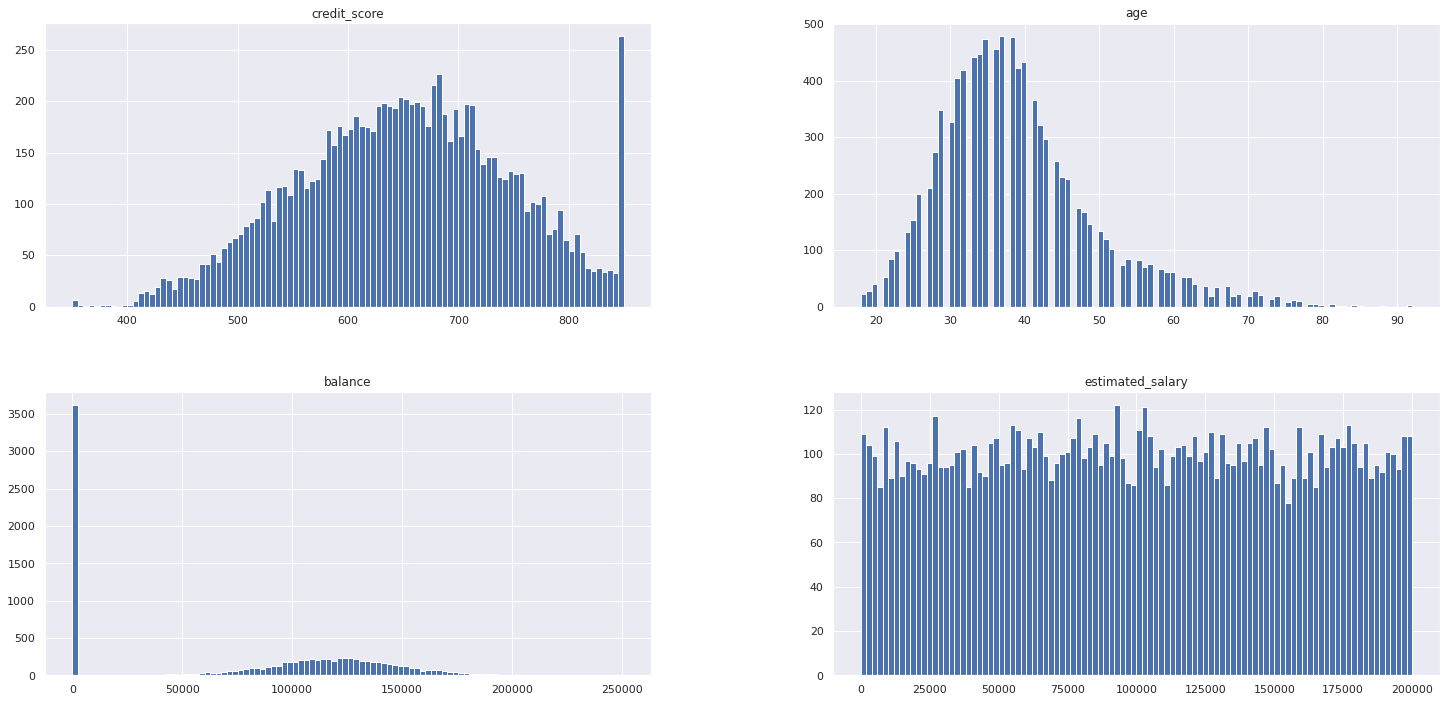

In [16]:
# plot histograms
num_attributes.hist(bins=100);

### 1.5.2. Categorical Attributes

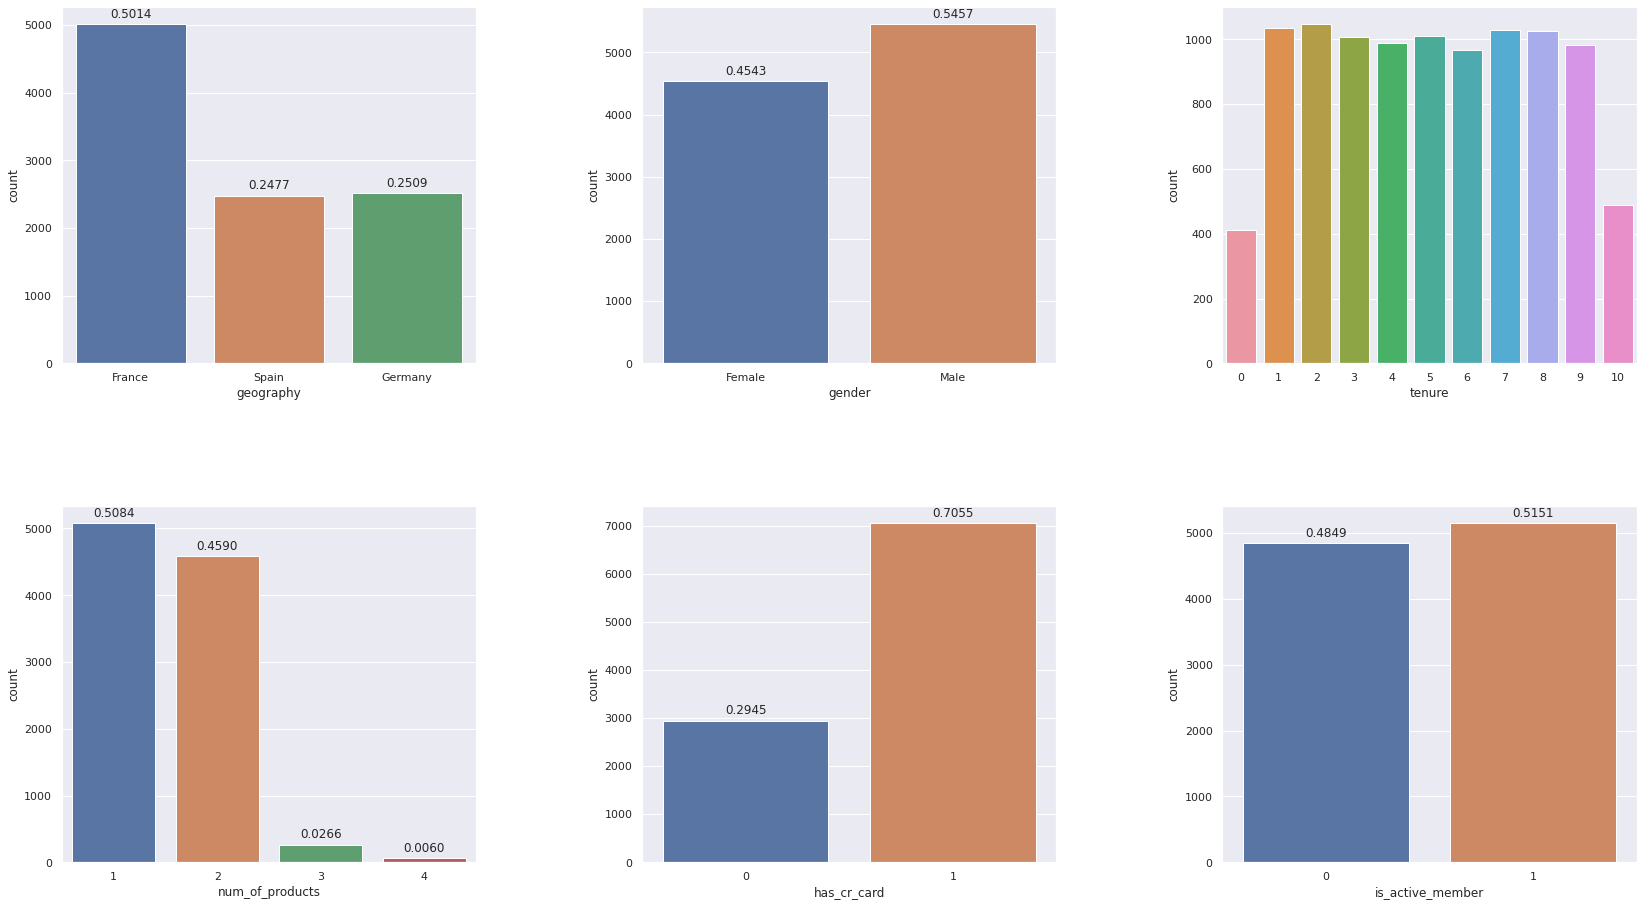

In [17]:
# create grid
grid = plt.GridSpec(2, 3)

# print countplot geography
plt.subplot(grid[0, 0])
plot_cat(cat_attributes['geography'])

# print countplot gender
plt.subplot(grid[0, 1])
plot_cat(cat_attributes['gender'])

# print countplot tenure
plt.subplot(grid[0, 2])
plot_cat(cat_attributes['tenure'], annot=False)

# print countplot num_of_products
plt.subplot(grid[1, 0])
plot_cat(cat_attributes['num_of_products'])

# print countplot has_cr_card
plt.subplot(grid[1, 1])
plot_cat(cat_attributes['has_cr_card'])

# print countplot is_active_member
plt.subplot(grid[1, 2])
plot_cat(cat_attributes['is_active_member'])

plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.40)

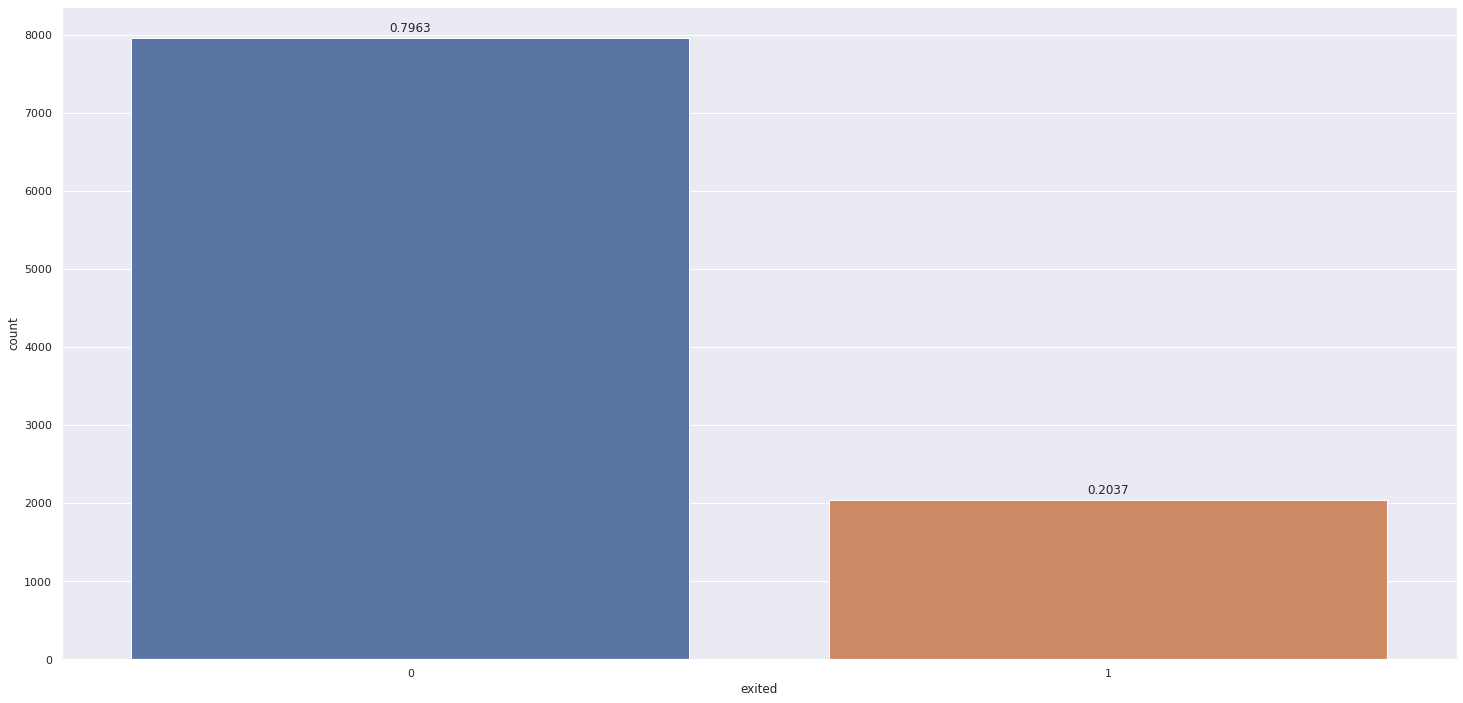

In [18]:
# variable target
plot_cat(cat_attributes['exited'])

obs: very umbalaced variable response

# 2.0. FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1. Hypothesis MindMap

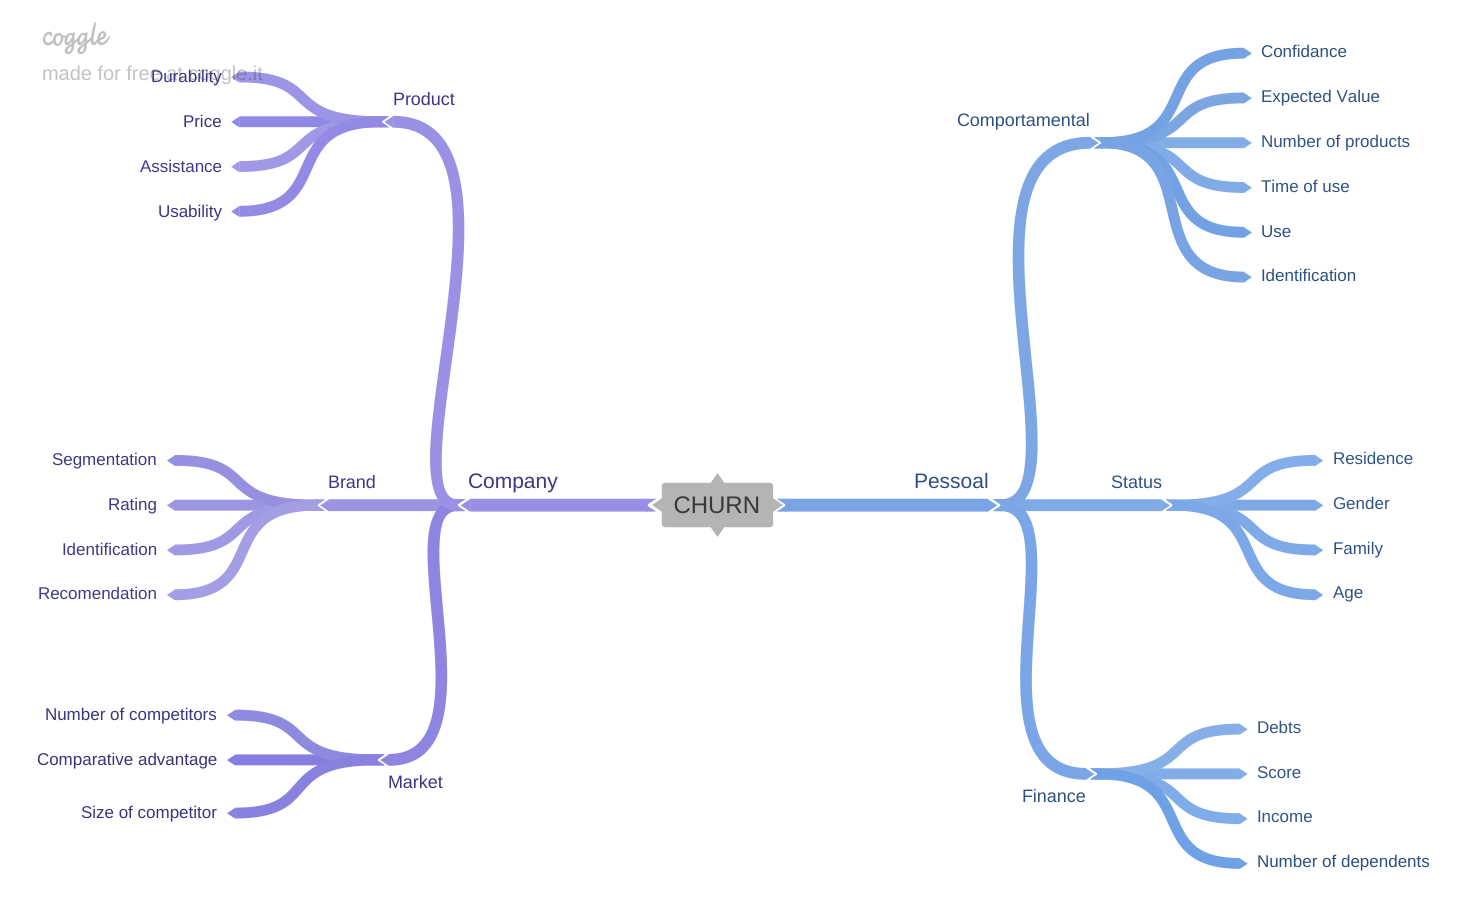

In [20]:
img_url = 'https://raw.githubusercontent.com/tadeucbm/churn_predict/main/image/CHURN.png'
Image(img_url)

## 2.2. Creation of Hypotheses

### 2.2.1. Hipóteses Comportamentais
**1**. Old customers have a lower dropout rate than new customers.;

**2**. Customers with more products evade less;

**3**. Customer with credit card tend to evaded less;

**4**. Longer credit card customers tend to evaded less;

**5**. Active customers tend to evaded less.


### 2.2.2. Hipóteses de Status
**1**. The customer residence country impacts the dropout rate;

**2**. The gender of the customer has no relation with dropout rate;

**3**. Older people tend to evaded less.


### 2.2.3. Hipóteses de Finança
**1**. Indebted people tend to evaded less;

**2**. Customers with a high salary tend to evaded less;

**3**. Customers with a high amount of money in account tend to evaded less (exclude 0);

**4**. Customer with any value in account tend to evaded less;

**5**. Customers with a high score and low amount of money on account tend to evaded more;

**6**. People with a high salary and a low amount of money on account tend to evaded more.


### 2.2.4. Hipóteses Pessoal
**1**. Non-active customers who do not have a credit card tend to evade more than non-active customers with a credit card;

**2**. Younger credit card customers tend to evade less;

**3**. People who have spent a higher percentage of life as a customer tend to evade less.

## 2.3. Hypothesis Final List

**1**. Old customers have a lower dropout rate than new customers.;

**2**. Customers with more products evade less;

**3**. Customer with credit card tend to evaded less;

**4**. Longer credit card customers tend to evaded less;

**5**. Active customers tend to evaded less;

**6**. The customer residence country impacts the dropout rate;

**7**. The gender of the customer has no relation with dropout rate;

**8**. Older people tend to evaded less;

**9**. Indebted people tend to evaded less;

**10**. Customers with a high salary tend to evaded less;

**11**. Customers with a high amount of money in account tend to evaded less (exclude 0);

**12**. Customer with any value in account tend to evaded less;

**13**. Customers with a high score and low amount of money on account tend to evaded more;

**14**. People with a high salary and a low amount of money on account tend to evaded more;

**15**. Non-active customers who do not have a credit card tend to evade more than non-active customers with a credit card;

**16**. Younger credit card customers tend to evade less;

**17**. People who have spent a higher percentage of life as a customer tend to evade less.

## 2.4. Feature Engineering

In [21]:
# percentage of life the person is a customer
df2['perc_tenure'] = df2['tenure'] / df2['age']
df2['perc_tenure'] = df2['perc_tenure'].astype('float64')

# comparison between score and money account
df2['score_account'] = df2['balance'] / df2['credit_score']

# creating classes for the score 
df2['score_class'] = df2['credit_score'].apply(lambda x: 'high_risk' if x < 500 else
                                                         'med_risk' if x >= 500 and x < 700 else
                                                         'low_risk' if x >= 700 and x < 800 else
                                                         'very_low_risk')

df2['age_category'] = df2['age'].apply(lambda x: '18 - 29' if x >= 18 and x <= 30 else
                                                 '30 - 39' if x >= 30 and x < 40 else
                                                 '40 - 49' if x >= 40 and x < 50 else
                                                 '50 - 59' if x >= 50 and x < 60 else
                                                 '60 +')

df2['have_balance'] = df2['balance'].apply(lambda x: 1 if x > 0 else 0)

df2['cat_salary'] = pd.cut(df2['estimated_salary'], 10)

In [22]:
# drop surname
df2.drop('surname', inplace=True, axis=1)

In [23]:
df2.dtypes

credit_score           int64
geography             object
gender                object
age                    int64
tenure                object
balance              float64
num_of_products       object
has_cr_card           object
is_active_member      object
estimated_salary     float64
exited                object
perc_tenure          float64
score_account        float64
score_class           object
age_category          object
have_balance           int64
cat_salary          category
dtype: object

# 3.0. Exploratory Data Analysis

In [24]:
df3 = df2.copy()

## 3.1. Univariate Analysis

### 3.1.1. Response Variable 
- The response variable is unbalanced;

- 79.6% not churn and 20.4% churn

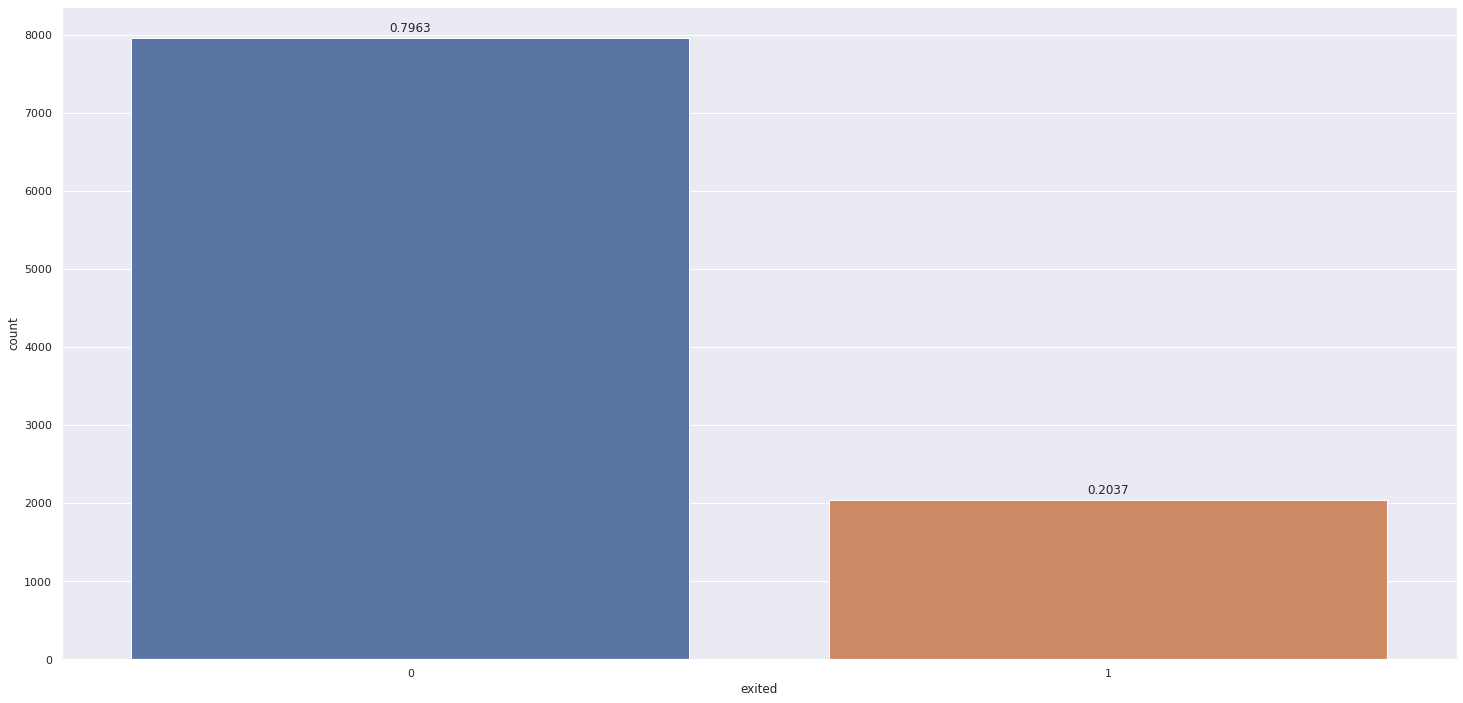

In [25]:
plot_cat(df3['exited'])

### 3.1.2. Numerical Variables

#### 3.1.2.1 Credit Score
- Credit_score is a variable that approaches a normal distribution,

- There are many entries with the maximum value

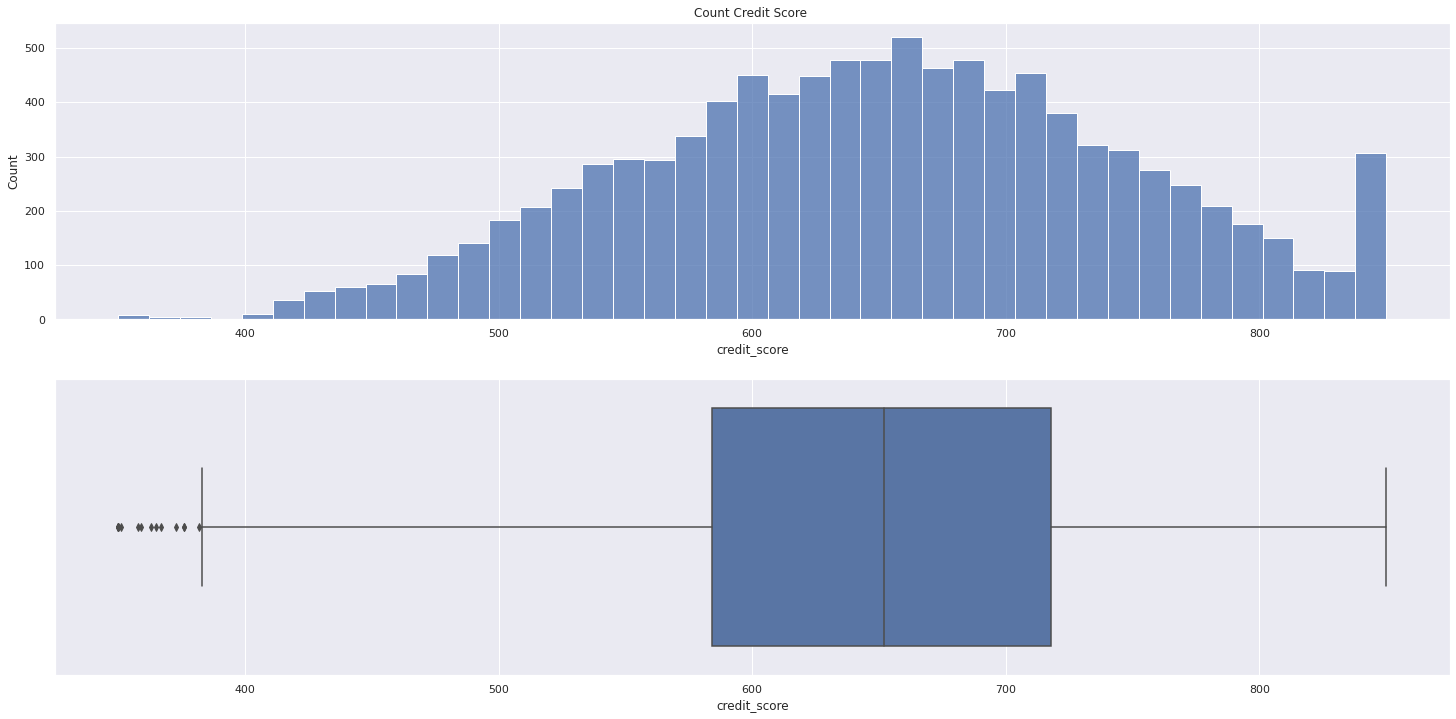

In [26]:
plot_dist(df3['credit_score'], title='Count Credit Score ')

#### 3.1.2.2 Age
- The skew of the variable age is positive

- Elderly people are outliers

- Some values of age stand out with high values

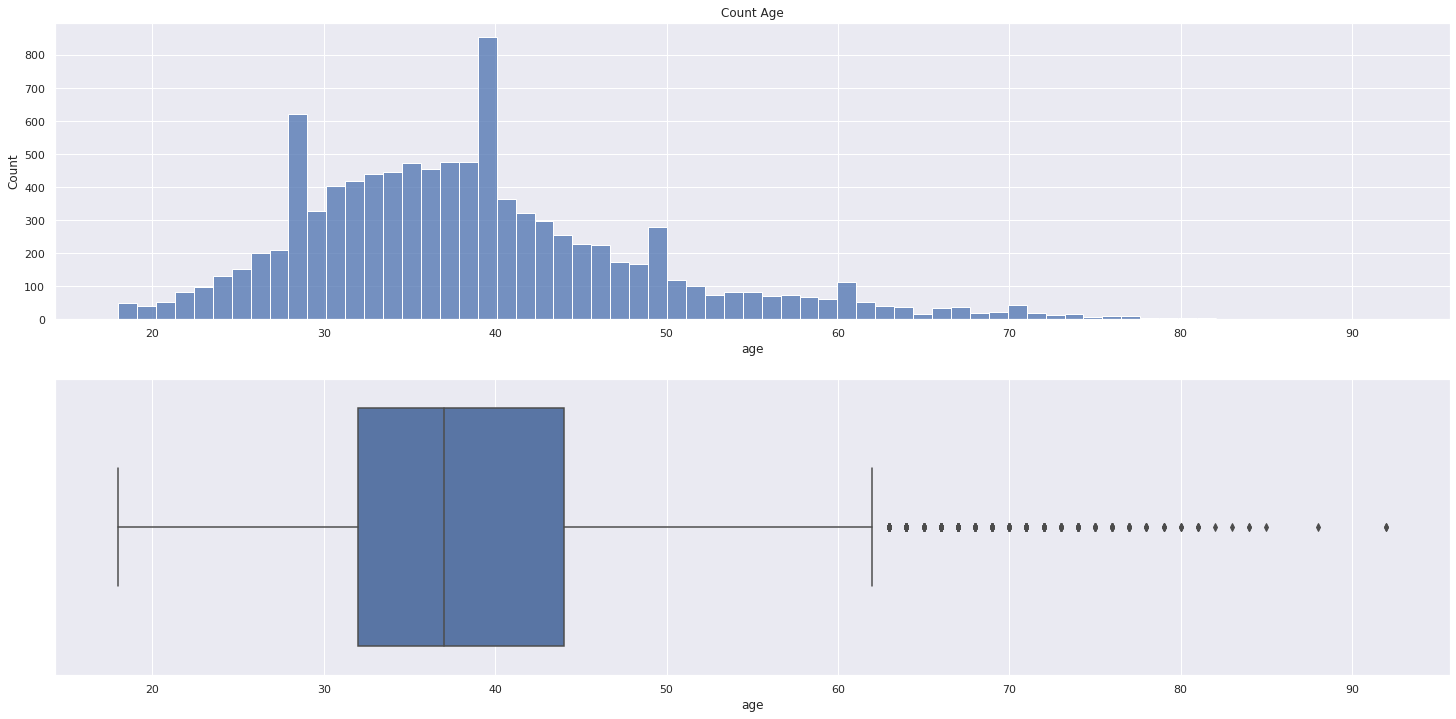

In [27]:
plot_dist(df3['age'], title='Count Age')

#### 3.1.2.3 Balance
- 36% of values are 0 and 64% of values are > 0

- The distribution of the balance variable approach to normal, when without 0 values

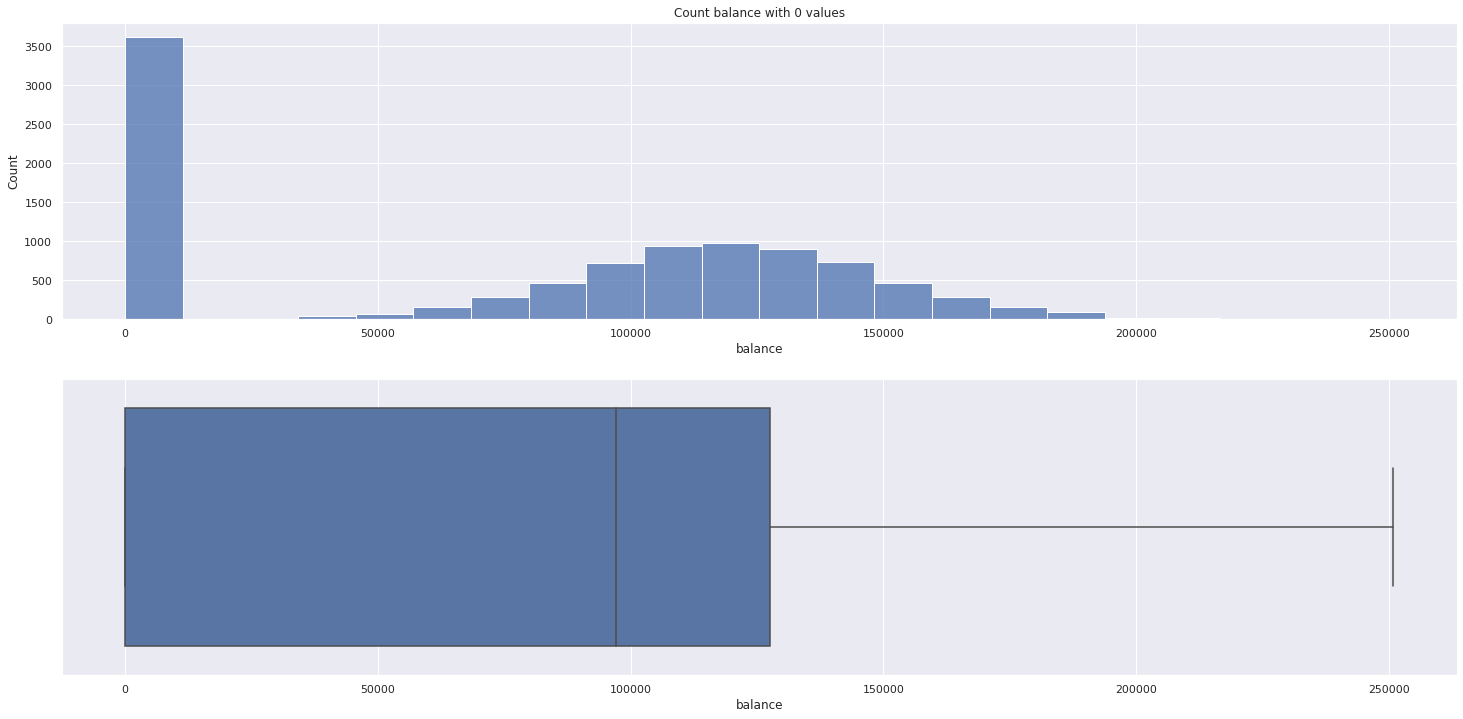

In [28]:
# plot balance with 0 balance values
plot_dist(df3['balance'], title='Count balance with 0 values')

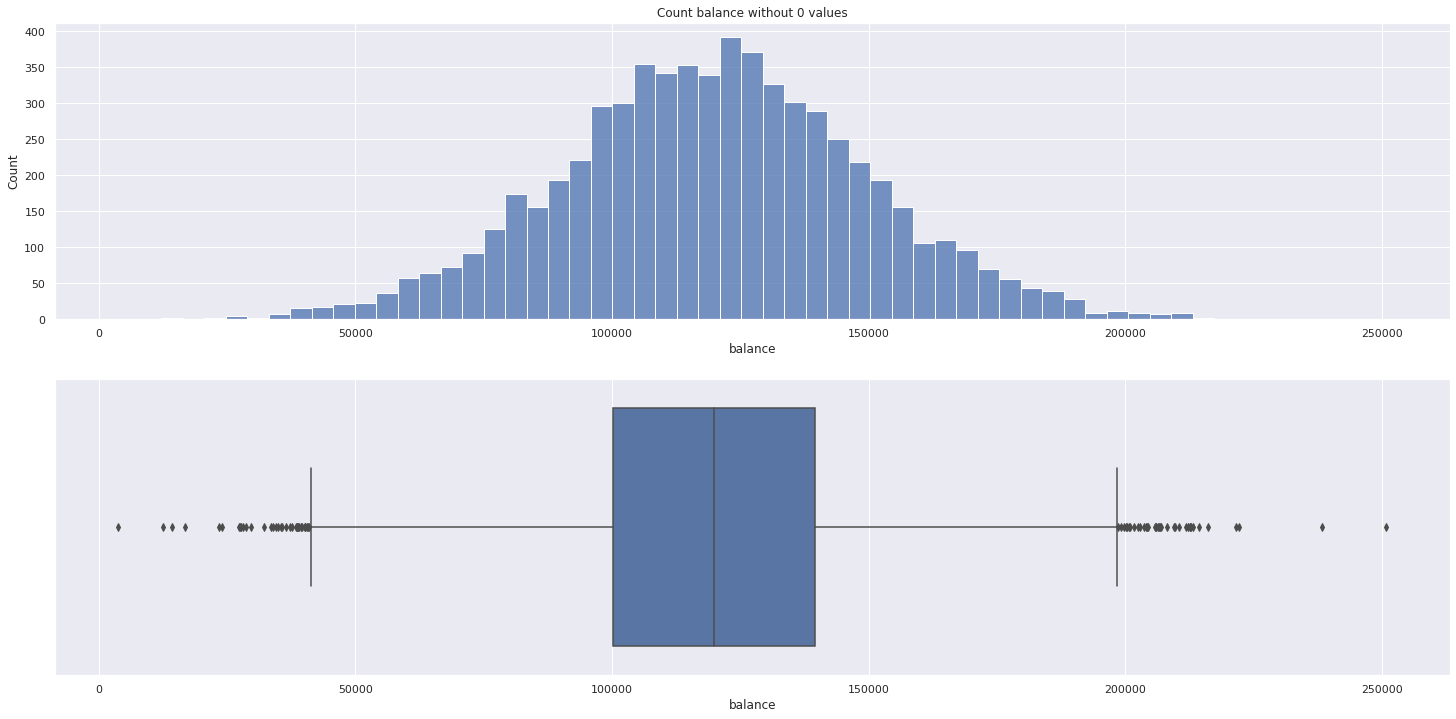

In [29]:
# histogram and boxplot of balance without 0 values
aux_2 = df3.loc[df3['balance'] > 0, 'balance']
plot_dist(aux_2, title='Count balance without 0 values')

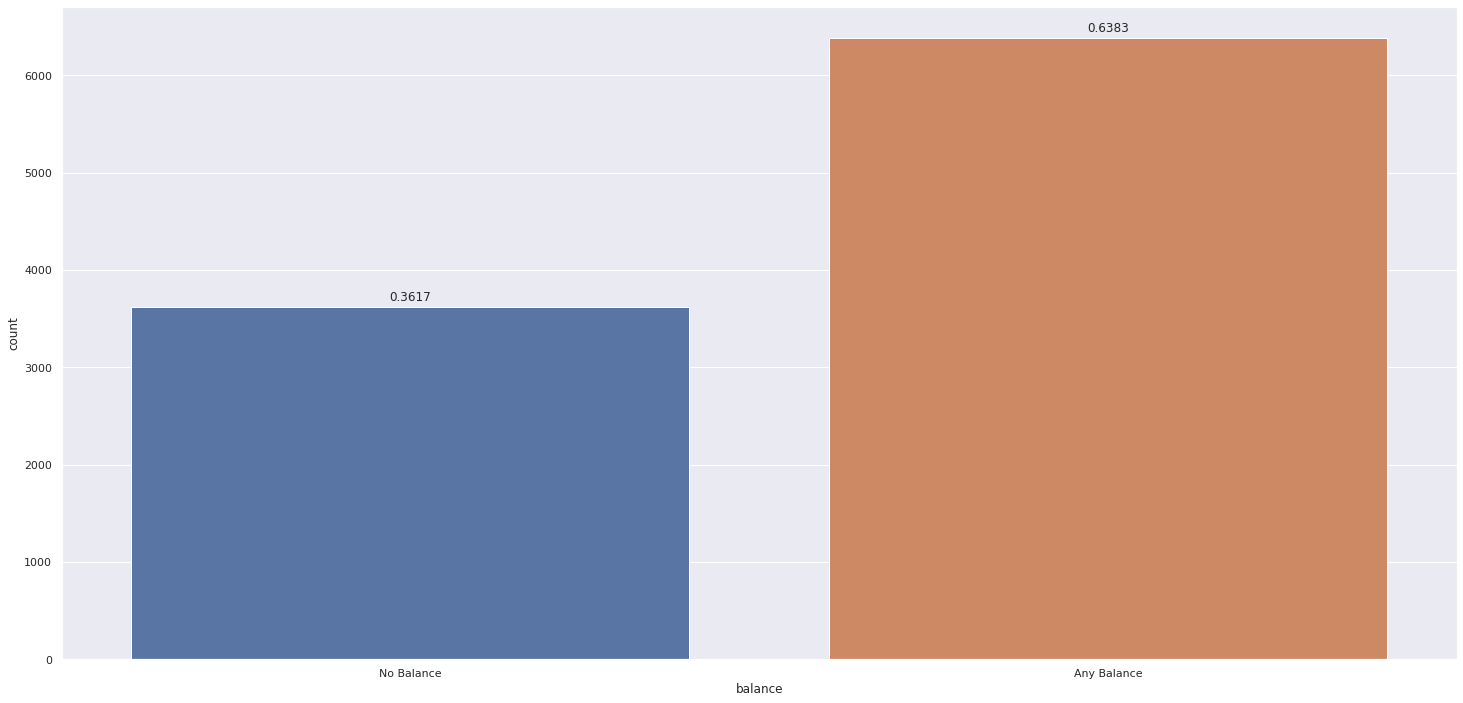

In [30]:
# count number of balance = 0 and balance > 0
aux_1 = df3['balance'].apply(lambda x: 'No Balance' if x == 0 else 'Any Balance')
plot_cat(aux_1)

#### 3.1.2.4 Estimated Salary
- The variable estimated salary is very balanced

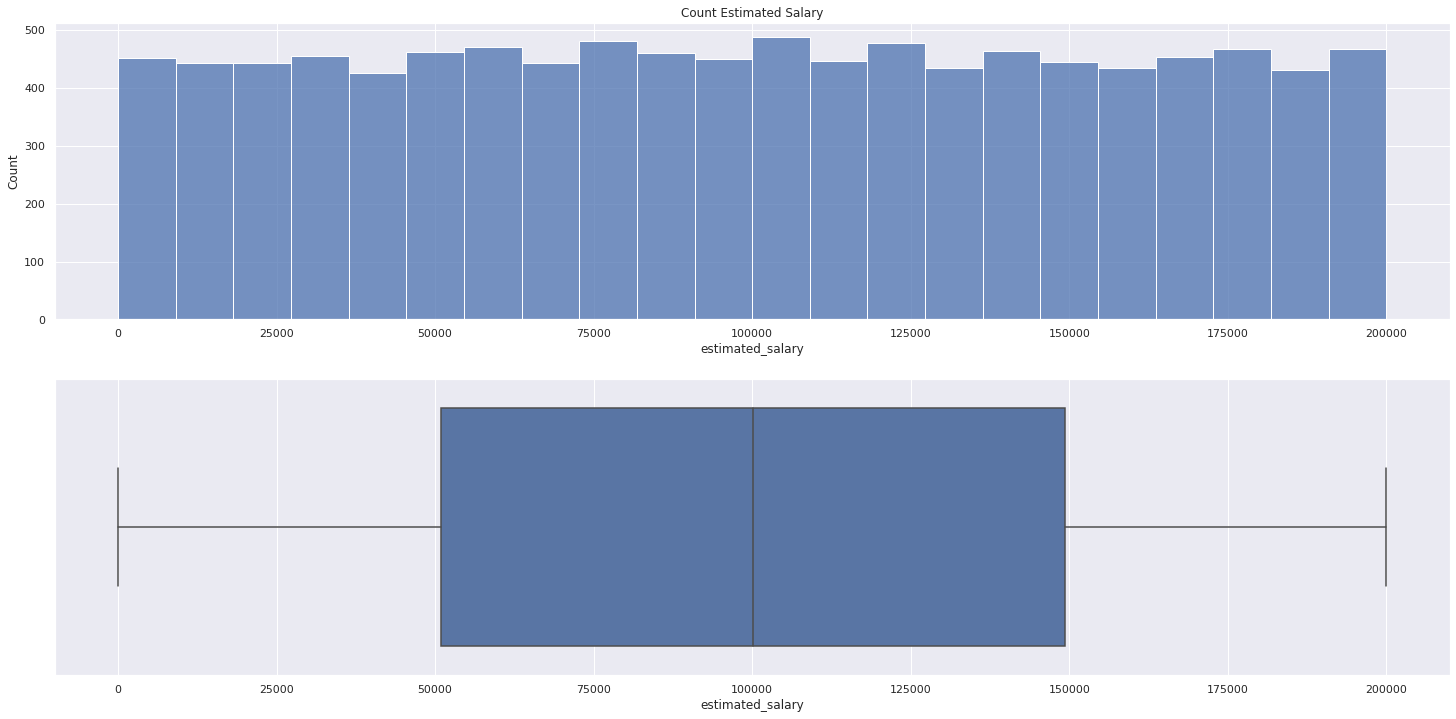

In [31]:
# plot balance with 0 balance values
plot_dist(df3['estimated_salary'], title='Count Estimated Salary')

#### 3.1.2.5 perc_tenure
- The skew of the variable perc_tenure is positive

- Values greater than 0.4 are outliers

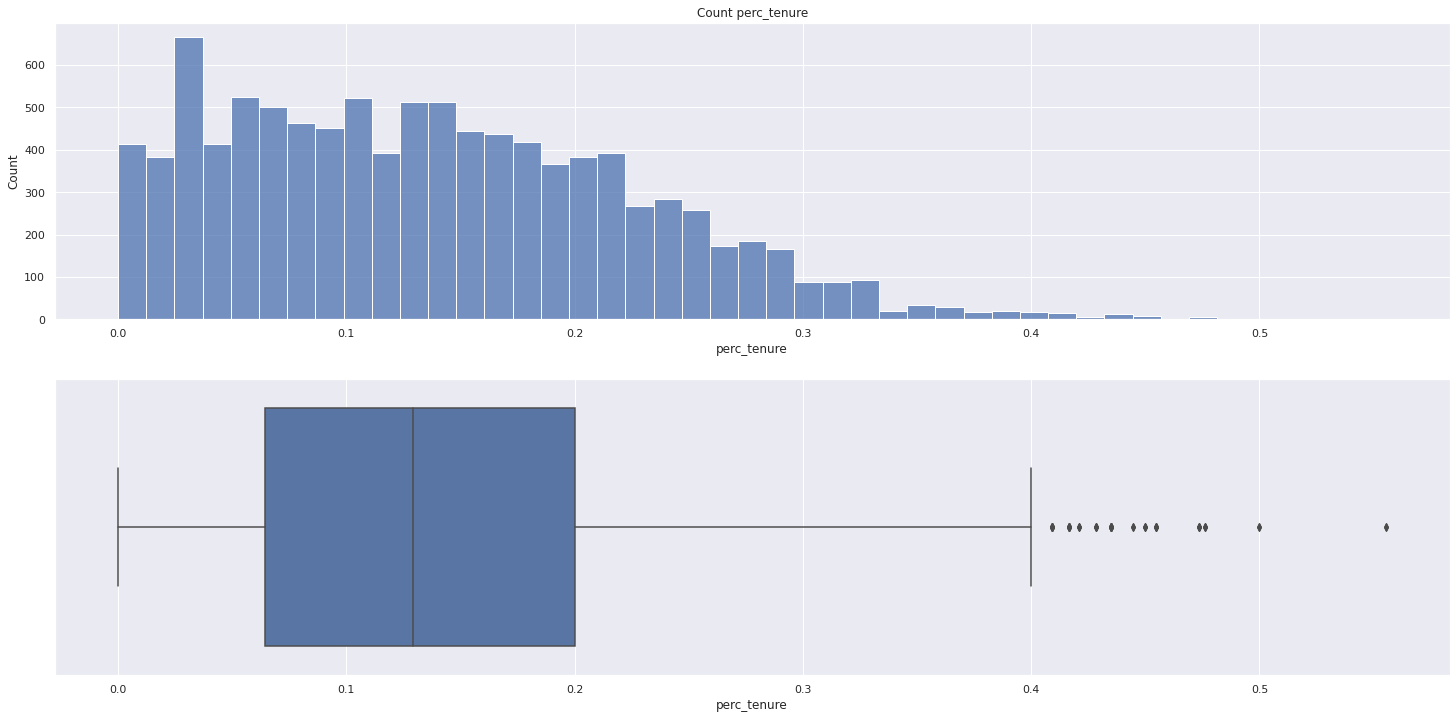

In [32]:
# plot perc_tenure
plot_dist(df3['perc_tenure'], title='Count perc_tenure')

#### 3.1.2.6 score_account
The distribution of the balance variable approach to normal, when without 0 values. But, your skew is positive.

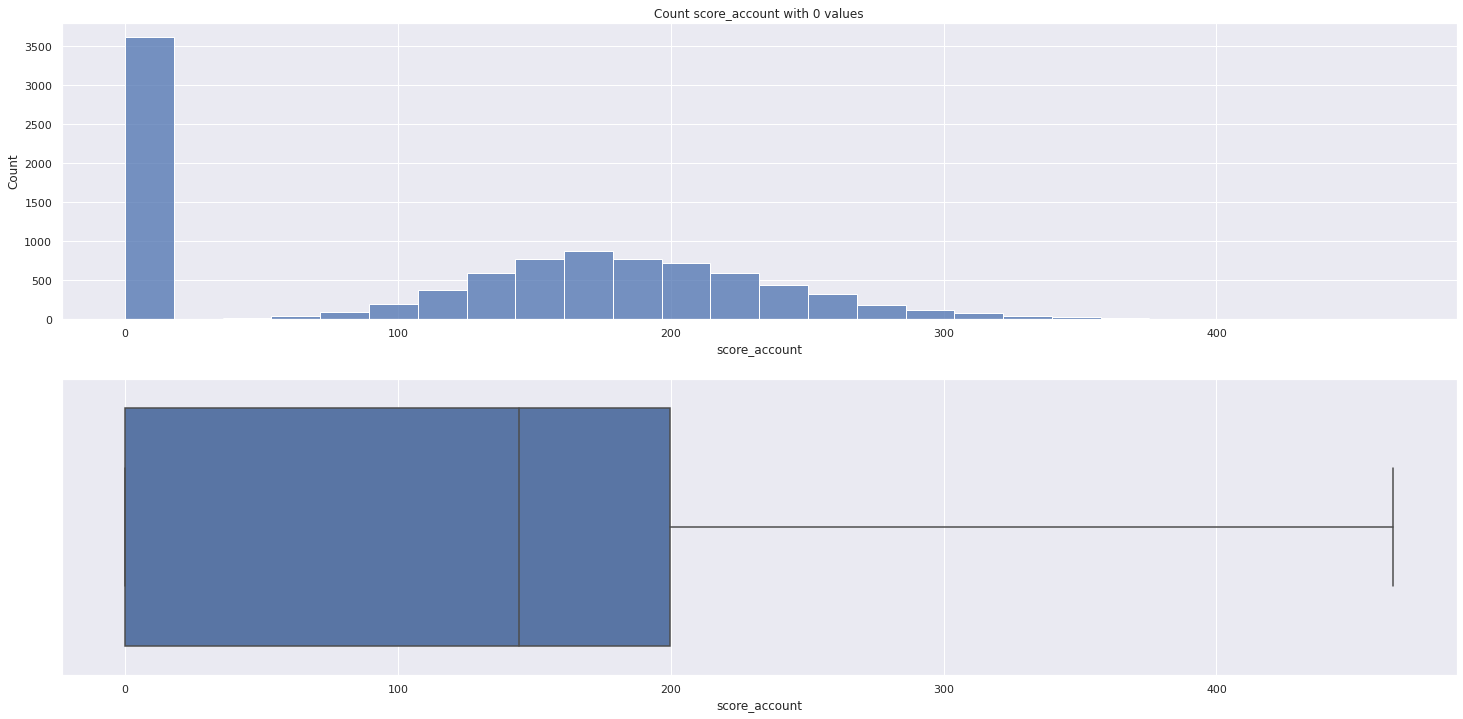

In [33]:
# plot score_account
plot_dist(df3['score_account'], title='Count score_account with 0 values')

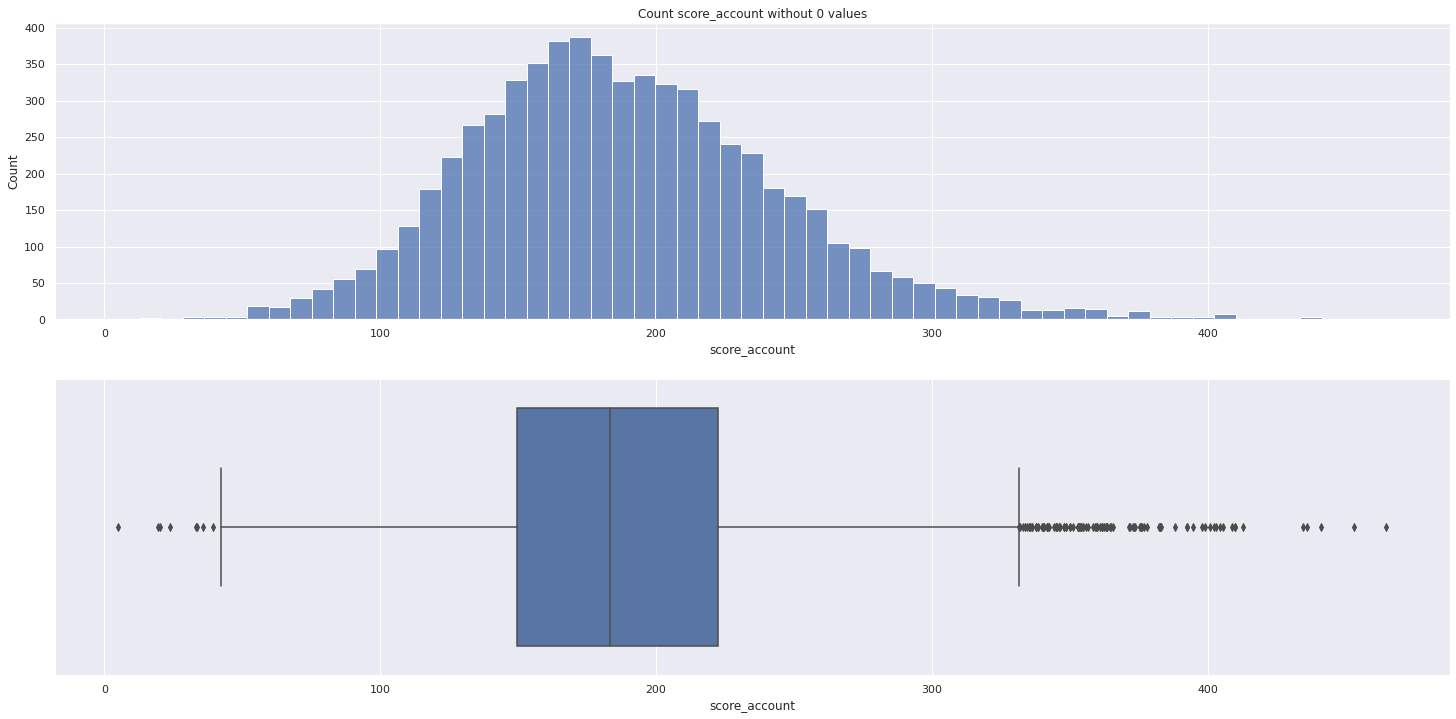

In [34]:
aux_2 = df3.loc[df3['score_account'] > 0, 'score_account']
plot_dist(aux_2, title='Count score_account without 0 values')

### 3.1.3. Categorical Variables

- More than half of the data are from French;

- More men than women;

- The time as a customer is well balanced, with the exception of the tips that are low;

- 95% of customers own up to 2 products;

- 70% of customers have a credit card;

- Approximately half of the customers are active, the other half are not.

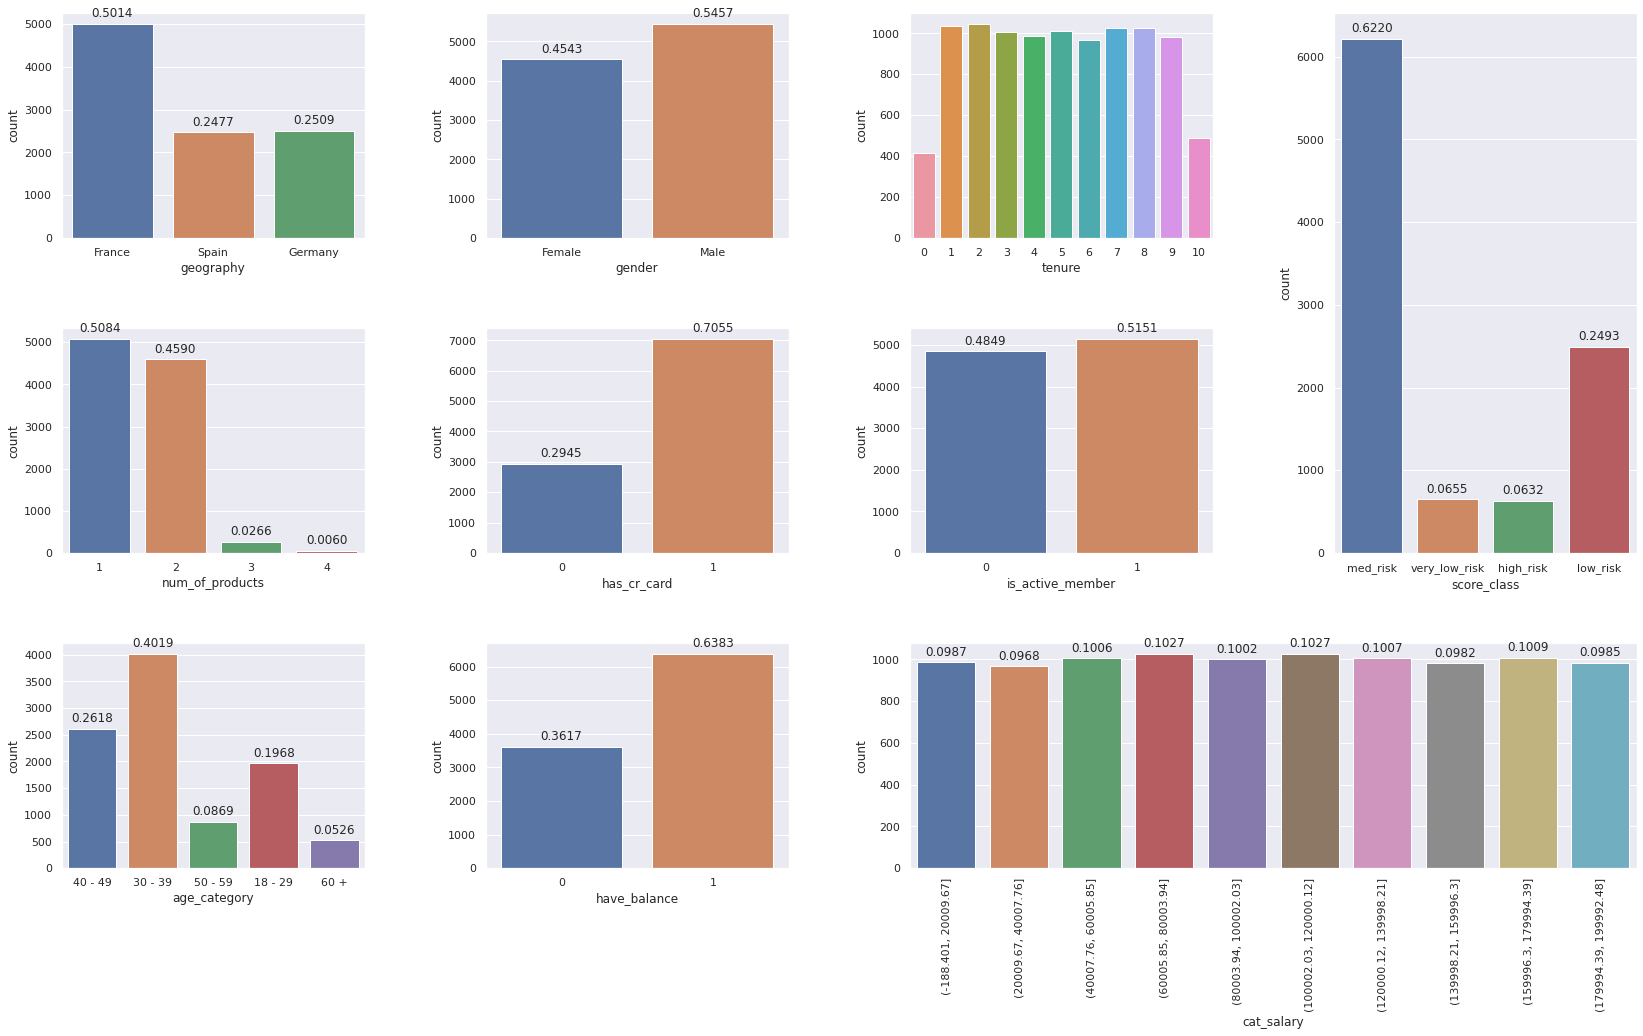

In [35]:
# create grid
grid = plt.GridSpec(3, 4)

# print countplot geography
plt.subplot(grid[0, 0])
plot_cat(df3['geography'])

# print countplot gender
plt.subplot(grid[0, 1])
plot_cat(df3['gender'])

# print countplot tenure
plt.subplot(grid[0, 2])
plot_cat(df3['tenure'], annot=False)

# print countplot num_of_products
plt.subplot(grid[1, 0])
plot_cat(df3['num_of_products'])

# print countplot has_cr_card
plt.subplot(grid[1, 1])
plot_cat(df3['has_cr_card'])

# print countplot is_active_member
plt.subplot(grid[1, 2])
plot_cat(df3['is_active_member'])

# print countplot is_active_member
plt.subplot(grid[2, 0])
plot_cat(df3['age_category'])

# print countplot is_active_member
plt.subplot(grid[2, 1])
plot_cat(df3['have_balance'])

# print countplot is_active_member
plt.subplot(grid[2, 2:4])
plot_cat(df3['cat_salary'])
plt.xticks(rotation=90)

# print countplot is_active_member
plt.subplot(grid[0:2, 3])
plot_cat(df3['score_class'])

plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.40)

## 3.2. Bivariate Analysis

### H1. Old customers have a lower dropout rate than new customers. - FALSE
Old customers have a slightly lower dropout rate than younger customers. However, the correlation between the variables is low.

In [36]:
# Create a crosstab with variables tenure and exited
aux = pd.crosstab(df3['tenure'], df3['exited']).reset_index()
aux['percent'] = aux[1] / (aux[0] + aux[1])

# create aux_2 dataframe
aux_2 = pd.DataFrame({k:1 for k in range(0, 11)}, index=[0]).T.reset_index()

<AxesSubplot:xlabel='index', ylabel='percent'>

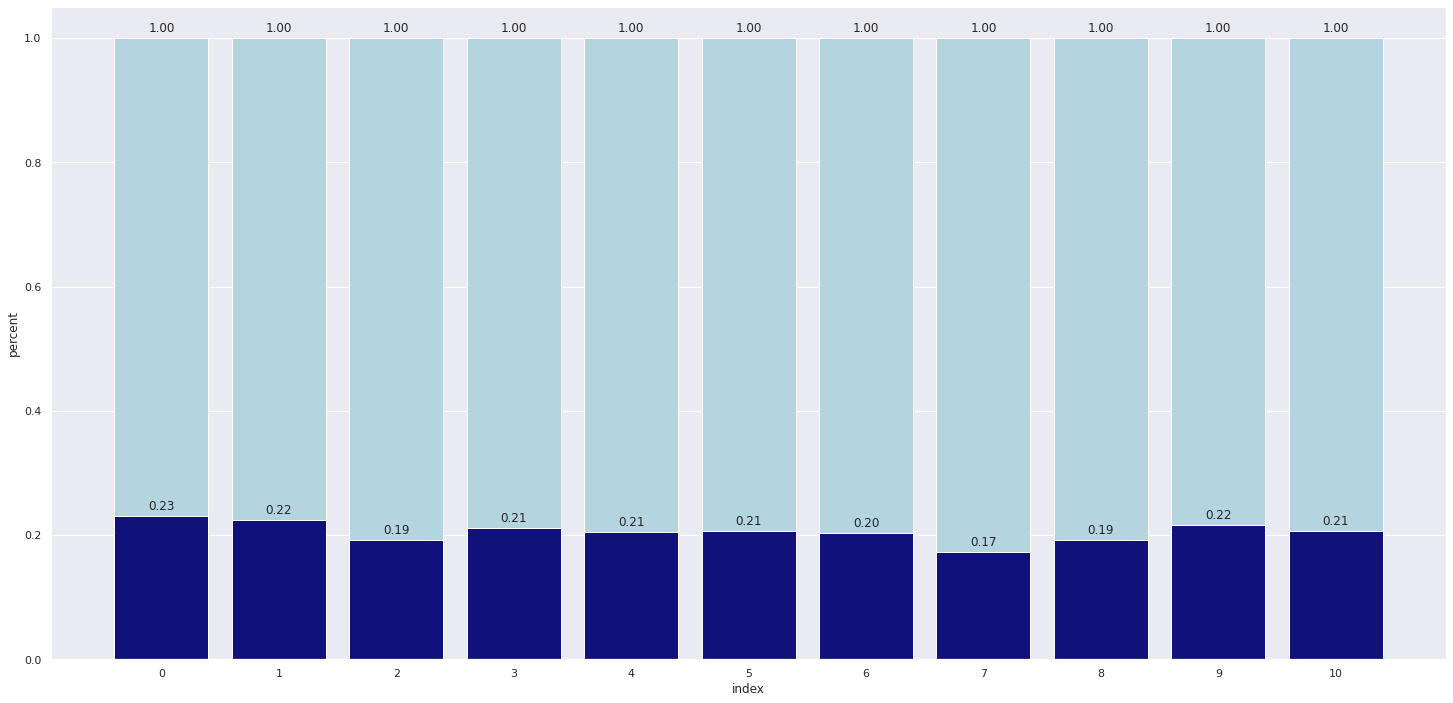

In [37]:
# plot percentage bar of each number of products
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=aux['percent'], color='darkblue')


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')
        
sns.lineplot(x = aux['percent'])

### H2. Customers with more products evade less - FALSE
The number of products has a peculiar behavior:
- 27.71% of customers with 1 products evaded;
- 7.58% of customers with 2 products evaded;
- **82.71%** of customers with 3 products evaded;
- **100%** of customers with 4 products evaded.

Therefore, customers with more products tend to evade more.

In [38]:
# Create a crosstab with variables numer_of_products and exited
aux = pd.crosstab(df3['num_of_products'], df3['exited'])
aux['percentage'] = round(aux[1] / (aux[0] + aux[1]), 4) * 100

In [39]:
aux

exited,0,1,percentage
num_of_products,,,
1,3675,1409,27.71
2,4242,348,7.58
3,46,220,82.71
4,0,60,100.00


Text(0.5, 1.0, 'Evasion or not for all number of products')

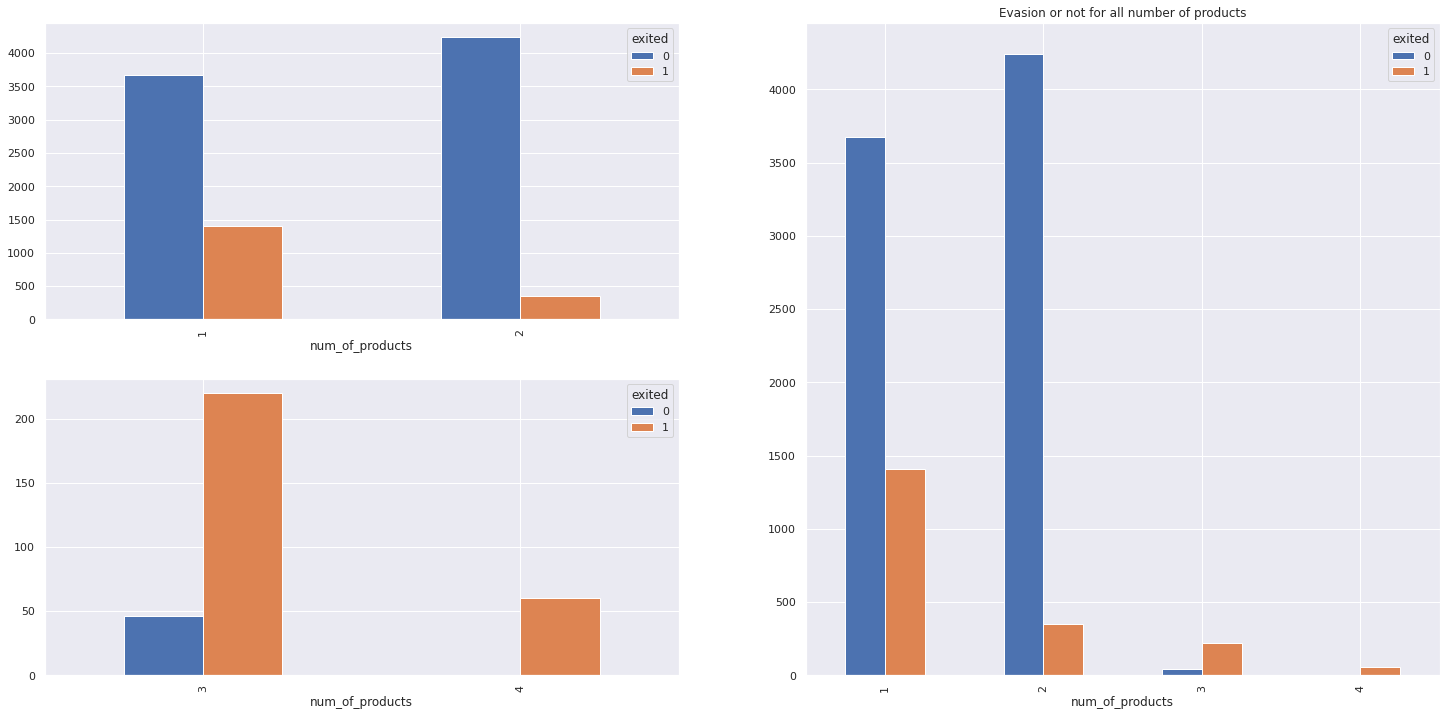

In [40]:
# create fig and grids
grid = plt.GridSpec(2, 2)
fig=plt.figure()
ax1=fig.add_subplot(grid[0, 0])
ax2=fig.add_subplot(grid[1, 0])
ax3=fig.add_subplot(grid[:, 1])

# 1 or 2 products
aux.iloc[:2, :-1].plot.bar(ax = ax1)

# 3 or 4 products
aux.iloc[2:, :-1].plot.bar(ax = ax2)

# all products
aux.iloc[:, :-1].plot.bar(ax = ax3)
plt.title('Evasion or not for all number of products')

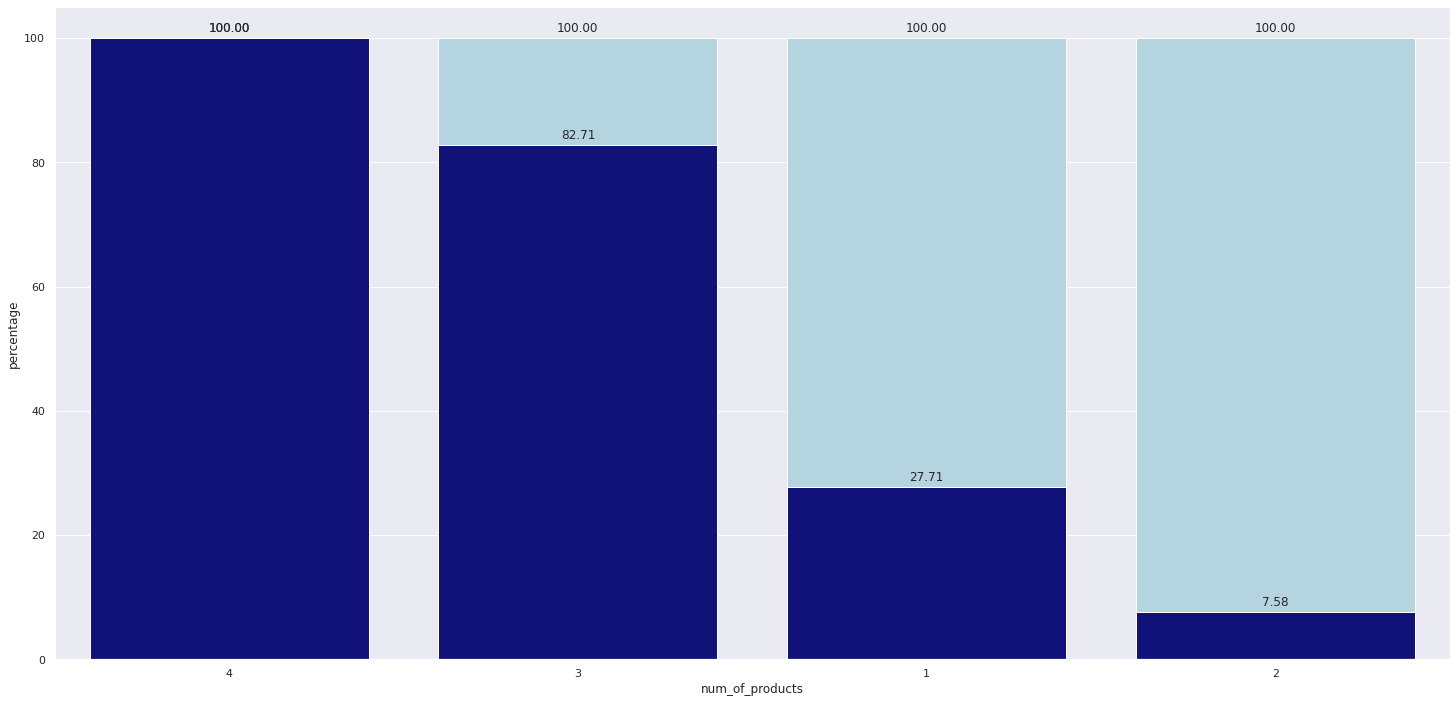

In [41]:
# auxiliar dataframe
aux_2 = pd.DataFrame({k:100 for k in range(1, 5)}, index=[0]).T.reset_index()

# plot percentage bar of each number of products
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], order=[4, 3, 1, 2], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=aux['percentage'], order=[4, 3, 1, 2], color='darkblue')


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H3. Customer with credit card tend to evaded less - FALSE
- No correlation between variables 'has_credit_card' and 'exited'

In [42]:
# Create a crosstab with variables has_cr_card and exited
aux = pd.crosstab(df3['has_cr_card'], df3['exited'])
aux['total'] = round(aux[1] / (aux[0] + aux[1]) * 100, 2)

# auxiliar dataframe
aux_2 = pd.DataFrame({0: 100, 1: 100}, index=[0]).T.reset_index()

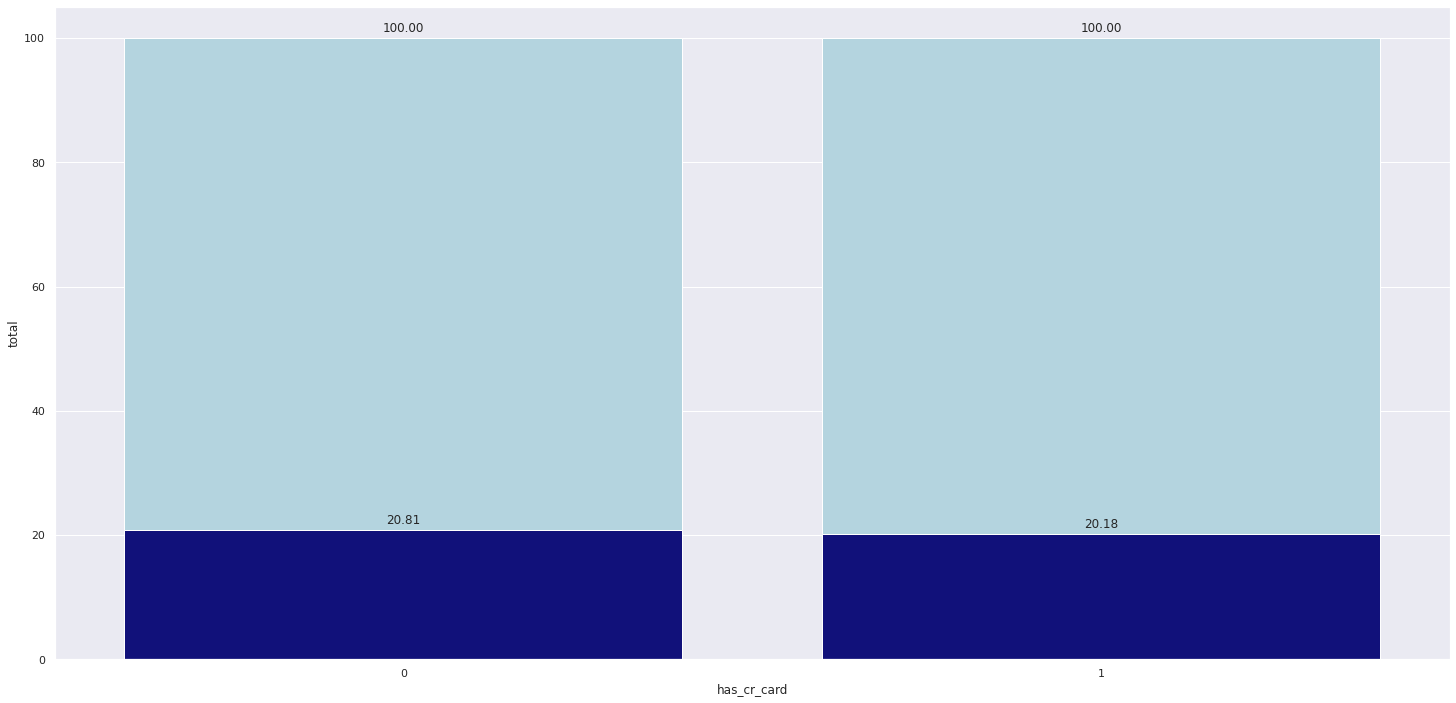

In [43]:
# plot percentage bar of each number of products
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=aux['total'], color='darkblue')


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H4. Longer credit card customers tend to evaded less - FALSE
- No correlation betweens this variables

In [44]:
# create aux -> crosstab 
aux = pd.crosstab(df3['exited'], [df3['has_cr_card'], df3['tenure']]).T
aux['percentage'] = aux[1] / (aux[0] + aux[1])

In [45]:
# create aux_2
aux_2 = aux.reset_index()
aux_2 = aux_2.loc[aux_2['has_cr_card'] == 1, :].reset_index(drop=True)
aux_2.index.name = 'index'
aux_2.sort_values(by='percentage', inplace=True)

In [46]:
# create aux_3 dataframe
aux_3 = pd.DataFrame({k:1 for k in range(0, 11)}, index=[0]).T.reset_index()

In [47]:
# Create aux_4 
aux_4 = pd.crosstab(df3['tenure'], df3['exited']).reset_index()
aux_4['percentage'] = aux_4[1] / (aux_4[0] + aux_4[1])

In [48]:
# Create aux_5 
aux_5 = pd.DataFrame([aux_2['percentage'], aux_4['percentage']]).T
aux_5.columns = ['percentage_all', 'percentage_old_credit']
aux_5['var'] = 1 - (aux_5['percentage_all'] / aux_5['percentage_old_credit'])

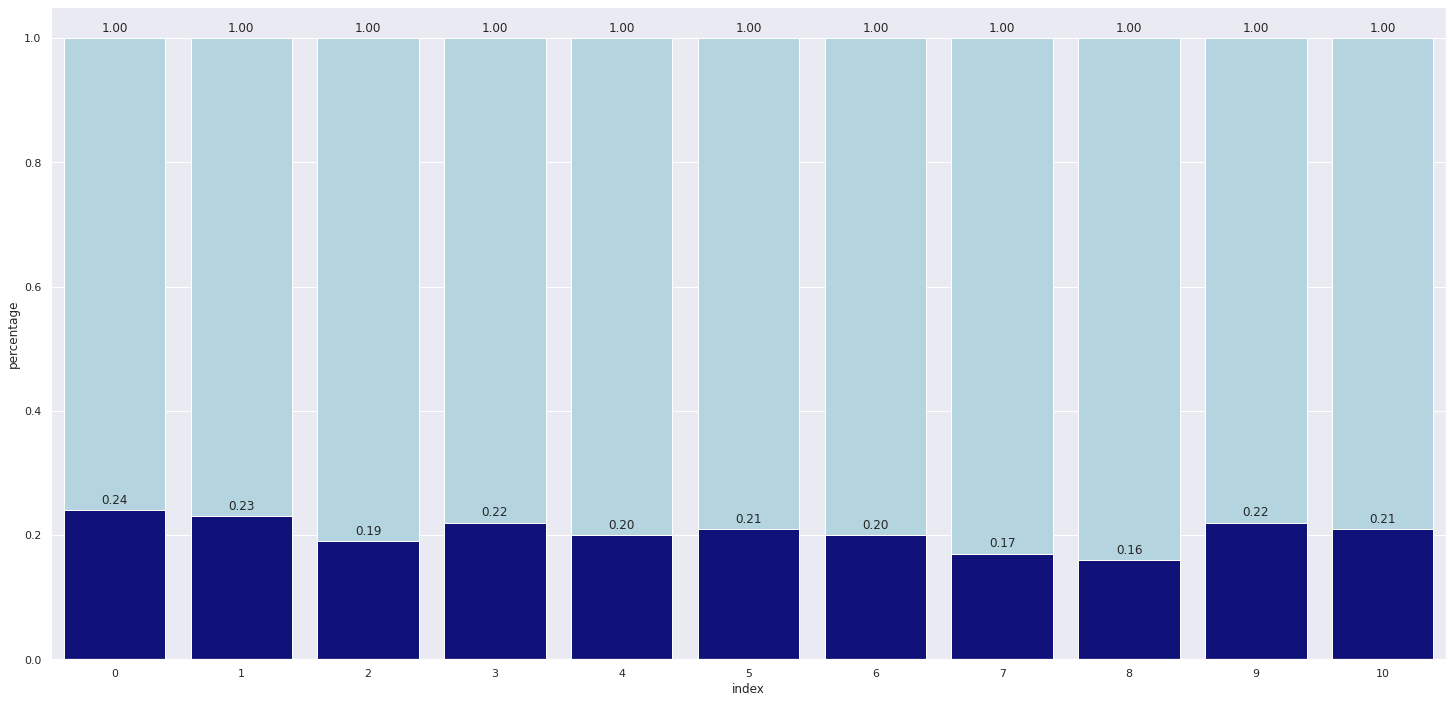

In [49]:
# plot percentage bar of each number of products
bar1 = sns.barplot(x=aux_3['index'], y=aux_3[0], color='lightblue')
bar2 = sns.barplot(x=aux_2.index, y=round(aux_2['percentage'], 2), color='darkblue')


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

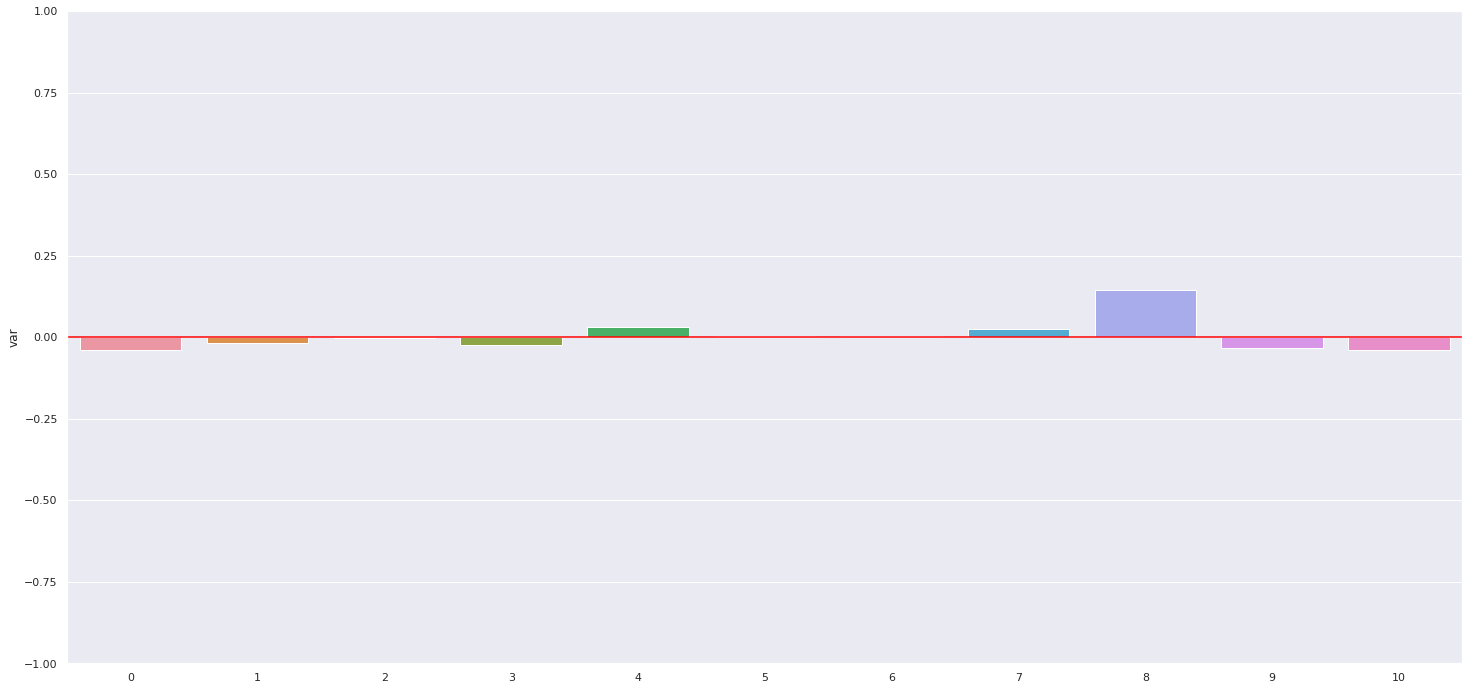

In [50]:
# plot variation between de percentage of tenure normal and tenure with credit_card
sns.barplot(x = aux_5.index, y = aux_5['var'], )

eixos = plt.gca()
eixos.set_ylim([-1, 1])

plt.axhline(y=0, color='red')

### H5. Active customers tend to evaded less. - TRUE
Non-active customers tend to evade more than active customers.

In [51]:
# create aux dataframe
aux = pd.crosstab(df3['is_active_member'], df3['exited']).reset_index(drop=True)
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100

In [52]:
# create aux_2 dataframe
aux_2 = pd.DataFrame({k:100 for k in range(0, 2)}, index=[0]).T.reset_index()

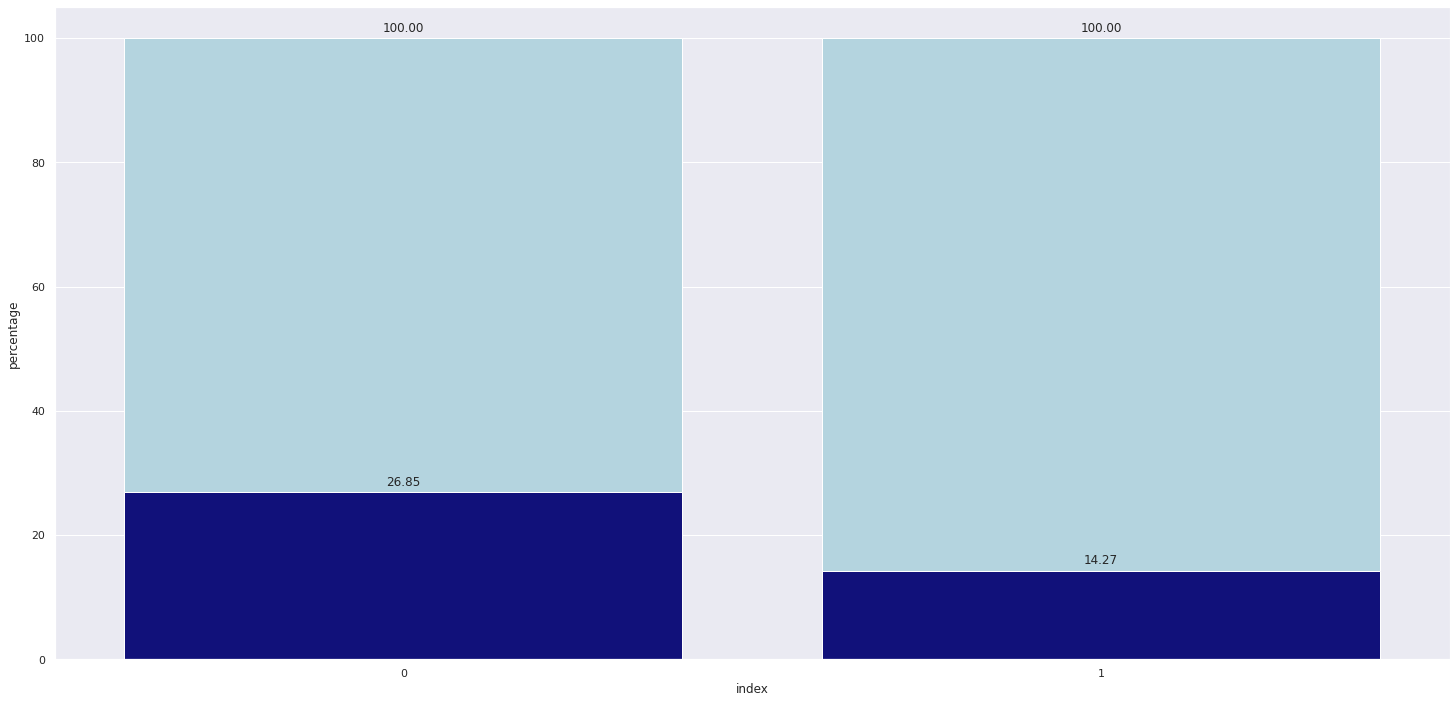

In [53]:
# plot percentage bar of each value for 'is_active_member'
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=round(aux['percentage'], 2), color='darkblue')


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H6. The customer residence country impacts the dropout rate - TRUE
the dropout rate for German customers is higher than for other customer nationalities.

In [54]:
# create aux -> crosstab 
aux = pd.crosstab(df3['geography'], df3['exited'])
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100
aux.sort_values(by='percentage', inplace=True, ascending=False)

In [55]:
# create aux_2 dataframe
aux_2 = pd.DataFrame({k:100 for k in range(0, 3)}, index=[0]).T.reset_index()

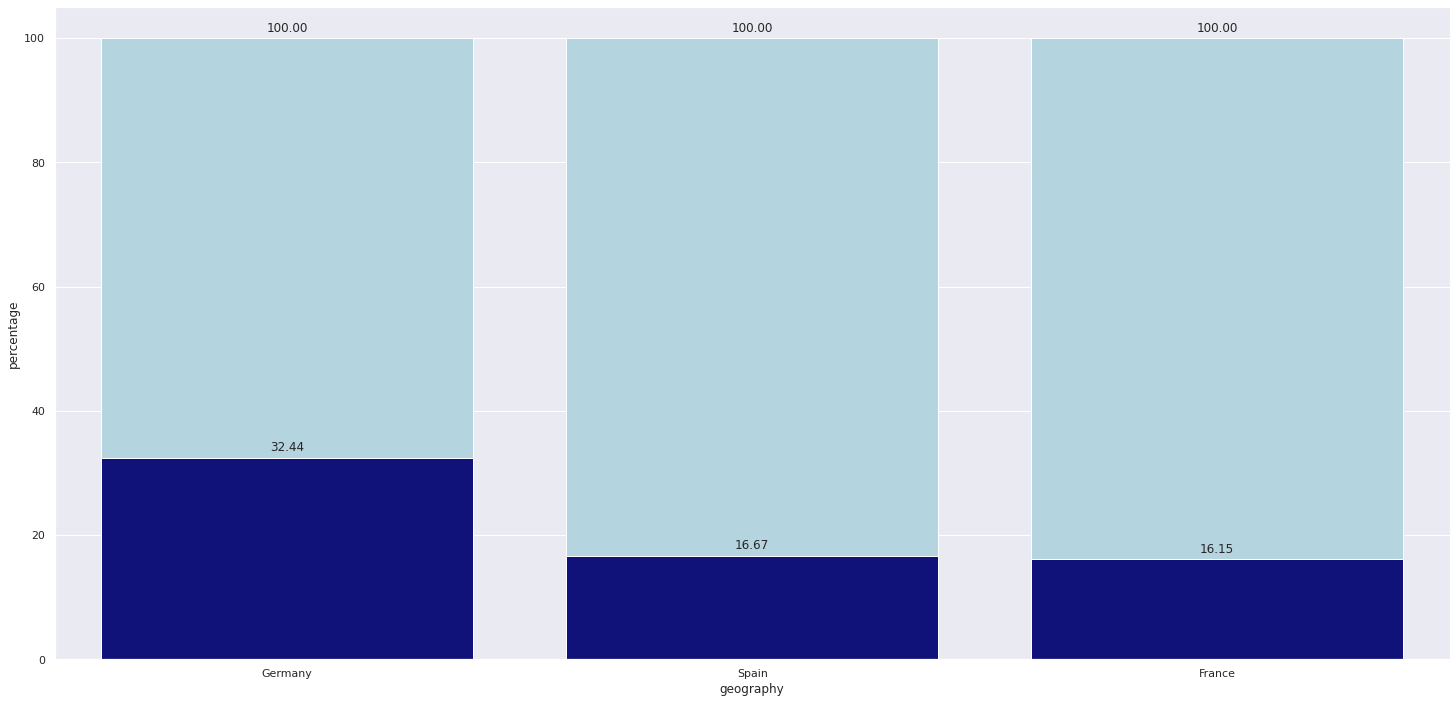

In [56]:
# plot percentage bar of each value for country
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=round(aux['percentage'], 2), color='darkblue', order = aux.index)


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H7. The gender of the customer has no relation with dropout rate. - FALSE
the female gender has a higher dropout rate.

In [57]:
# create aux -> crosstab 
aux = pd.crosstab(df3['gender'], df3['exited'])
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100
aux.sort_values(by='percentage', inplace=True, ascending=False)

In [58]:
# create aux_2 dataframe
aux_2 = pd.DataFrame({k:100 for k in range(0, 2)}, index=[0]).T.reset_index()

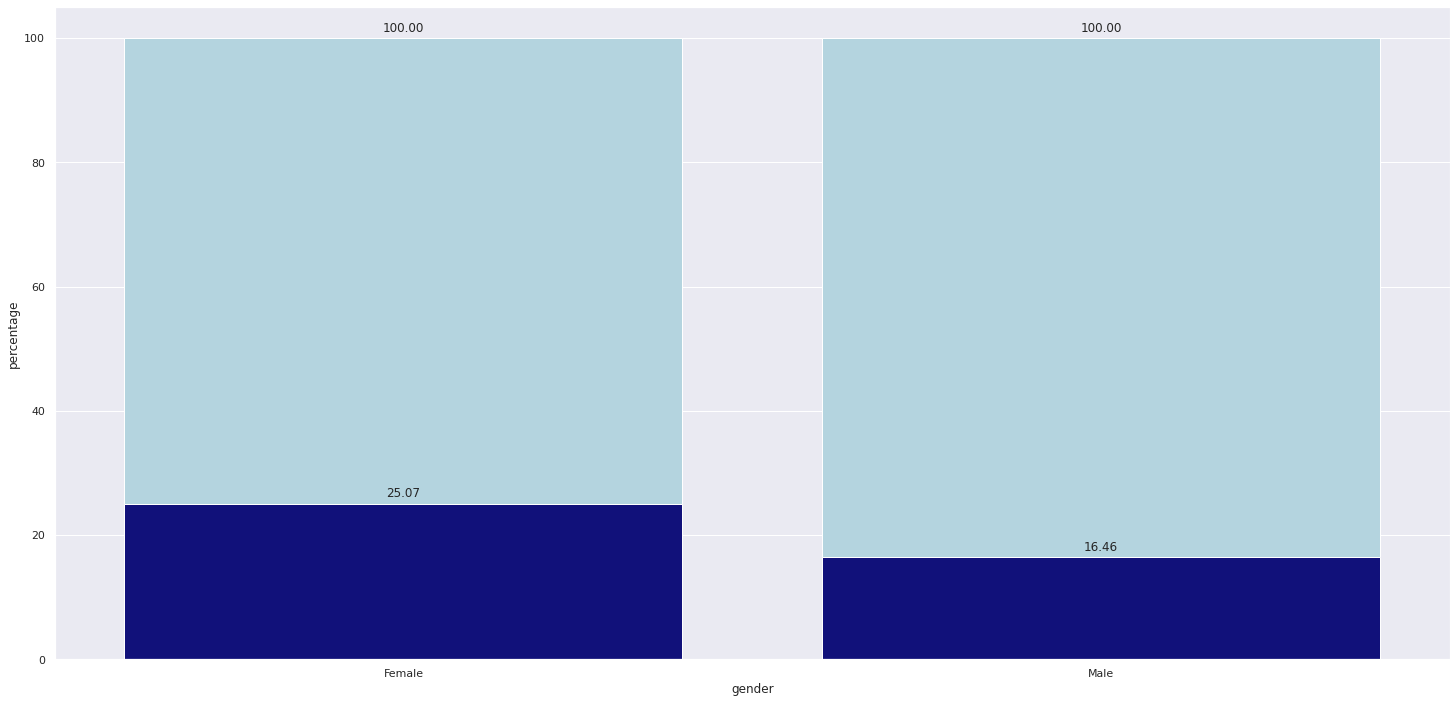

In [59]:
# plot percentage bar of each value for gender
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=round(aux['percentage'], 2), color='darkblue', order = aux.index)


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H8. Older people tend to evaded less - FALSE
Older people tend to evaded more. However, after 60 years of age, the dropout rate decreases.

In [60]:
# create aux - crosstab between agr_category and exited - with percentage of 1
aux = pd.crosstab(df3['age_category'], df3['exited'])
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100

In [61]:
# create aux_2 dataframe
aux_2 = pd.DataFrame({k:100 for k in range(0, 5)}, index=[0]).T.reset_index()

<AxesSubplot:xlabel='exited', ylabel='age'>

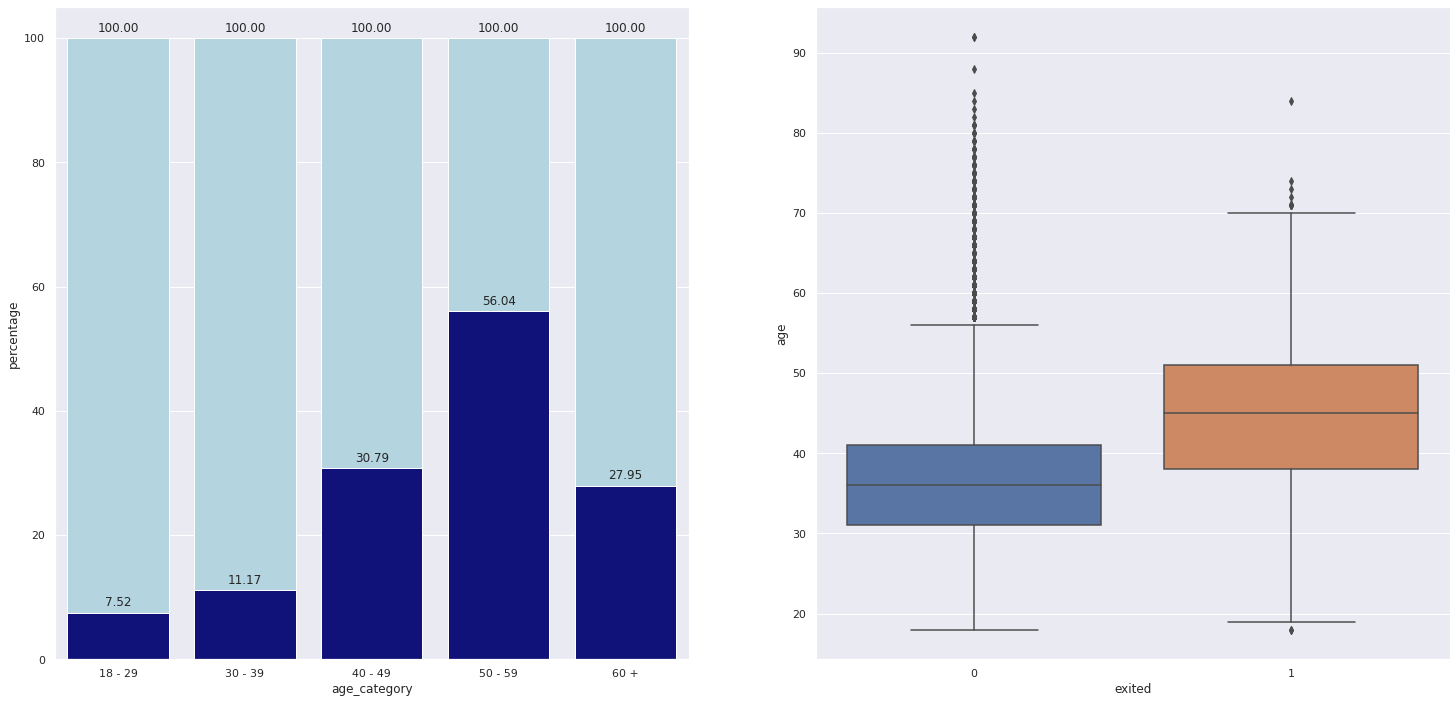

In [62]:
grid = plt.GridSpec(1, 2)

plt.subplot(grid[0, 0])
# plot percentage bar of each value for age_category
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=round(aux['percentage'], 2), color='darkblue', order = aux.index)


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')
        
plt.subplot(grid[0, 1])
sns.boxplot(x=df3['exited'], y=df3['age'])

### H9. Indebted people tend to evaded less - FALSE
There is a tendency to evade customers with lower scores (high risk). However, this trend is not high enough.

In [63]:
# create aux - crosstab between score_class and exited - with percentage of 1
aux = pd.crosstab(df3['score_class'], df3['exited'])
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100
aux.sort_values(by='percentage', inplace=True, ascending=False)

In [64]:
# create aux_2 dataframe
aux_2 = pd.DataFrame({k:100 for k in range(0, 4)}, index=[0]).T.reset_index()

<AxesSubplot:xlabel='exited', ylabel='credit_score'>

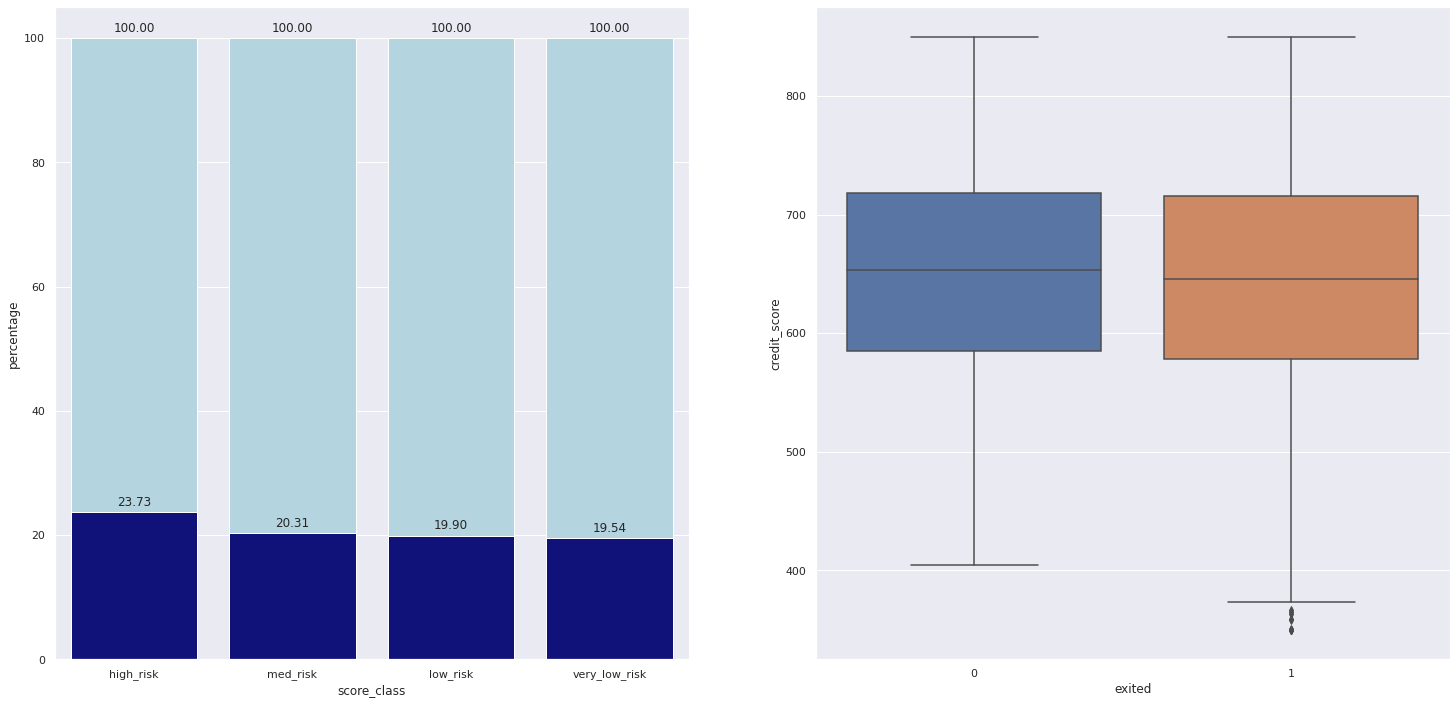

In [65]:
grid = plt.GridSpec(1, 2)

plt.subplot(grid[0, 0])
# plot percentage bar of each value for score_class
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=round(aux['percentage'], 2), color='darkblue', order = aux.index)


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')
        
plt.subplot(grid[0, 1])
sns.boxplot(x=df3['exited'], y=df3['credit_score'])

### H10. Customers with a high salary tend to evaded less - FALSE
No correlation between these variables

In [66]:
# creating aux that groups exited and estimated_salary by mean
aux = df3[['estimated_salary', 'exited']].groupby('exited').mean().reset_index()

In [67]:
# copy df3 in aux_2
aux_2 = df3.copy()

# create aux that agroup estimated salary in categories and give your percentage
aux_3 = pd.crosstab(aux_2['exited'], aux_2['cat_salary']).T
aux_3['percentage'] = aux_3[1] / (aux_3[0] + aux_3[1]) * 100

In [68]:
# create aux_4 dataframe
aux_4 = pd.DataFrame({k:100 for k in range(0, 10)}, index=[0]).T.reset_index()

<AxesSubplot:xlabel='exited', ylabel='estimated_salary'>

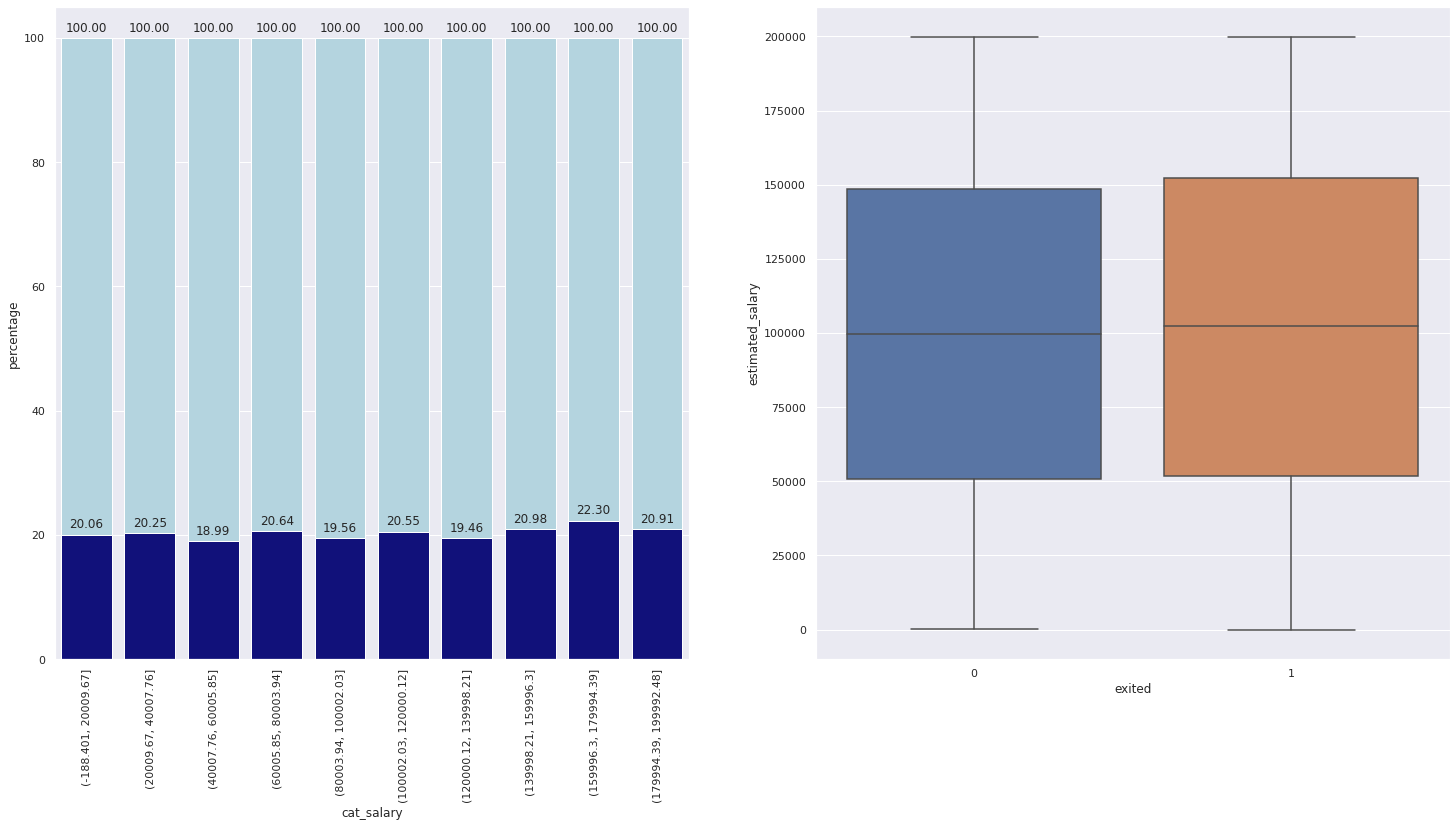

In [69]:
grid = plt.GridSpec(1, 2)

plt.subplot(grid[0, 0])

# plot percentage bar of each value for score_class
bar1 = sns.barplot(x=aux_4['index'], y=aux_4[0], color='lightblue')
bar2 = sns.barplot(x=aux_3.index, y=round(aux_3['percentage'], 2), color='darkblue', order = aux_3.index)
plt.xticks(rotation=90)

# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

# plot boxplot of salary and exited
plt.subplot(grid[0, 1])
sns.boxplot(x=df3['exited'], y=df3['estimated_salary'])

### H11. Customers with a high amount of money in account tend to evaded less (exclude 0) - FALSE
- The distribution of balance amounts is similar in both cases. The median age is the same.

In [70]:
# create aux with only values balance > 0
aux = df3.loc[df3['balance'] > 0, :]

In [71]:
# creating aux that groups exited and balance by mean
aux_2 = aux[['balance', 'exited']].groupby('exited').mean().reset_index()

In [72]:
# create aux crosstab balance and exited
aux_3 = pd.crosstab(aux['balance'], aux['exited'])
aux_3['percentage'] = aux_3[1] / (aux_3[0] + aux_3[1]) * 100

In [73]:
# select only exited values = 1
aux_4 = aux_3.loc[aux_3[1] == 1, :].reset_index()

<AxesSubplot:xlabel='exited', ylabel='balance'>

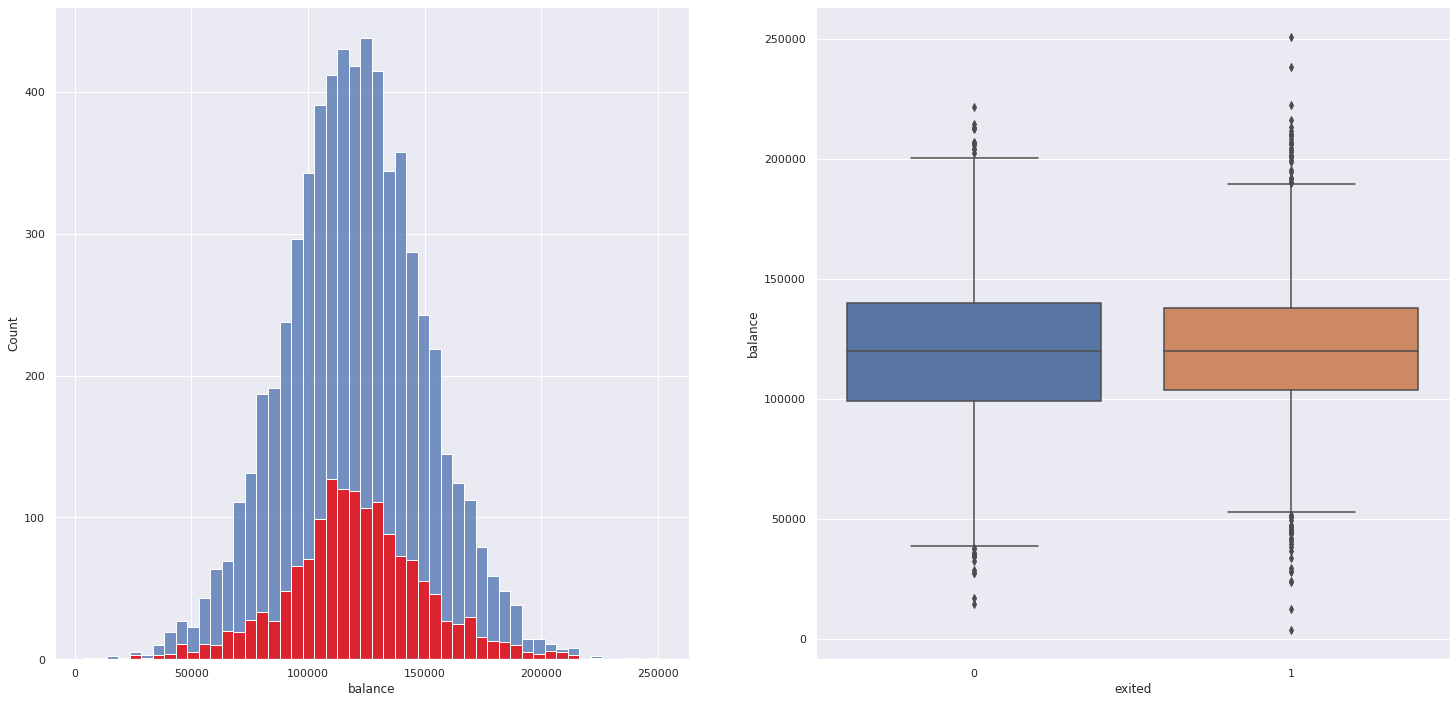

In [74]:
grid = plt.GridSpec(1, 2)

plt.subplot(grid[0, 0])
sns.histplot(x=aux['balance'], bins=50)
sns.histplot(x=aux_4['balance'], color='red', bins=50)

plt.subplot(grid[0, 1])
sns.boxplot(x=aux['exited'], y=aux['balance'])

### H12. Customer with any value in account tend to evaded less - FALSE
In the data, people with values in account evade more.

In [75]:
# create aux
aux = pd.crosstab(df3['have_balance'], df3['exited'])#.reset_index()
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100

In [76]:
# create aux_2 dataframe
aux_2 = pd.DataFrame({k:100 for k in range(0, 2)}, index=[0]).T.reset_index()

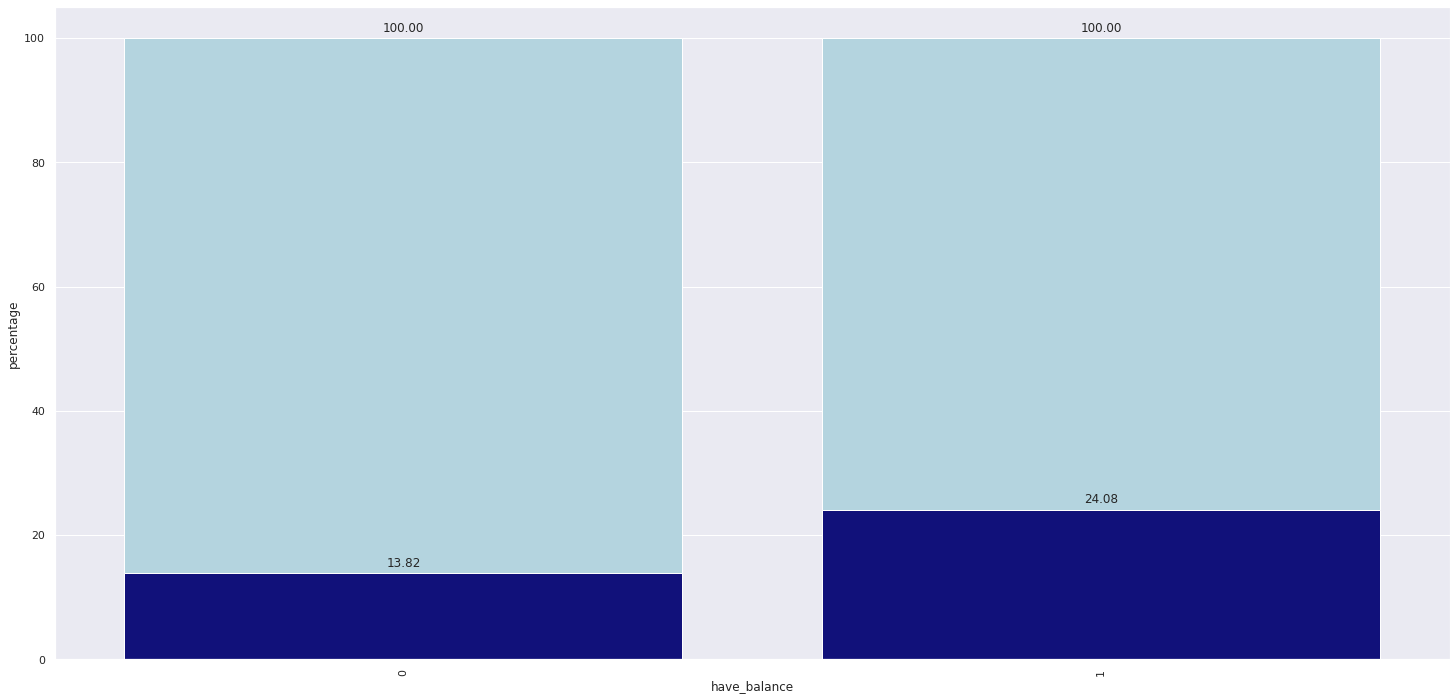

In [77]:
# plot percentage bar of each value for have_balance
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux.index, y=round(aux['percentage'], 2), color='darkblue', order = aux.index)
plt.xticks(rotation=90)

# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H13. Customers with a high score and low amount of money on account tend to evaded more - FALSE
- For any score level, customers who evade have a higher account money average.

In [78]:
# create aux DafaFrame
aux = df3[['exited', 'score_class', 'balance']].groupby(['score_class', 'exited']).mean().reset_index()

<AxesSubplot:xlabel='score_class', ylabel='balance'>

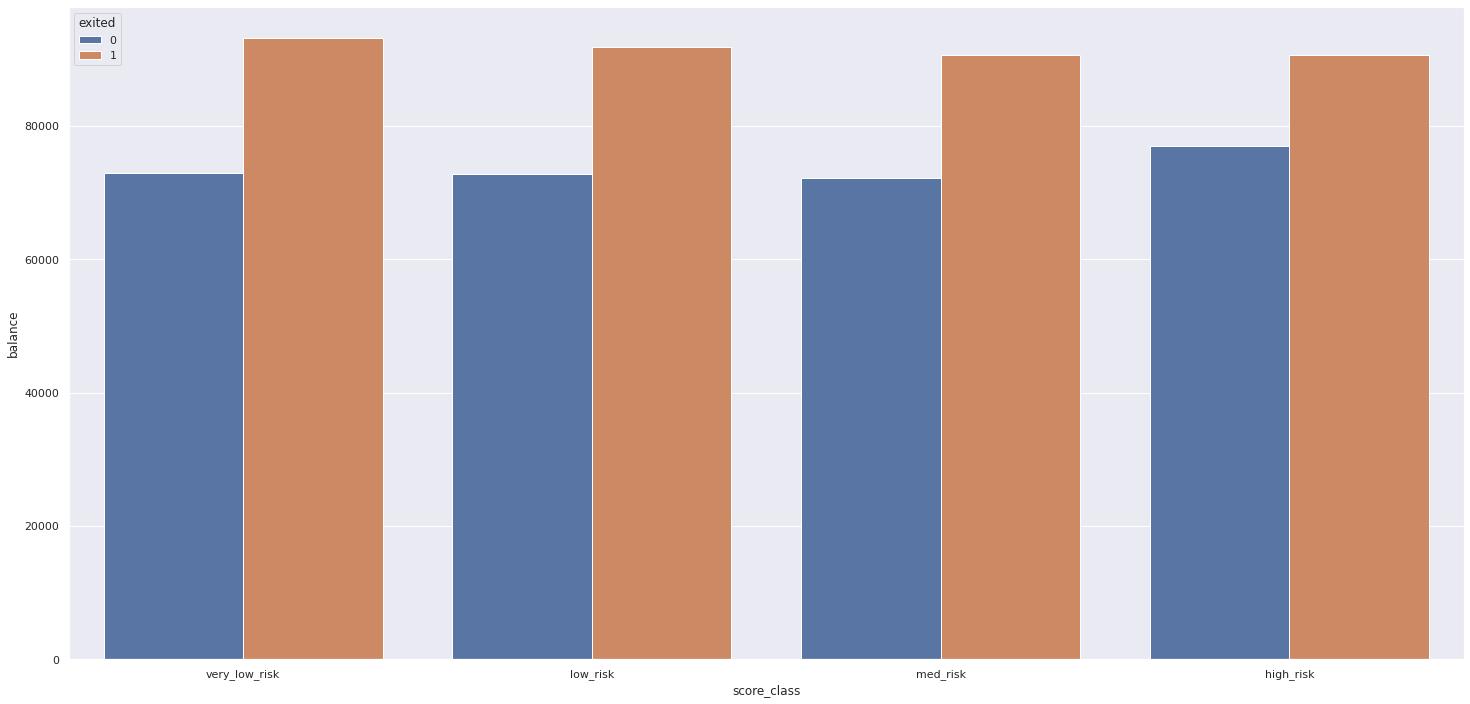

In [79]:
# plot barplot
sns.barplot(x='score_class', y='balance', hue='exited', data=aux, order=['very_low_risk', 'low_risk', 'med_risk', 'high_risk'])

### H14. People with a high salary and a low amount of money on account tend to evaded more - FALSE
For any salary level, clients who evade have a higher average cash account.

In [80]:
# create a final aux DataFrame to plot
aux = df3[['exited', 'cat_salary', 'balance']].groupby(['cat_salary', 'exited']).mean().reset_index()

<AxesSubplot:xlabel='cat_salary', ylabel='balance'>

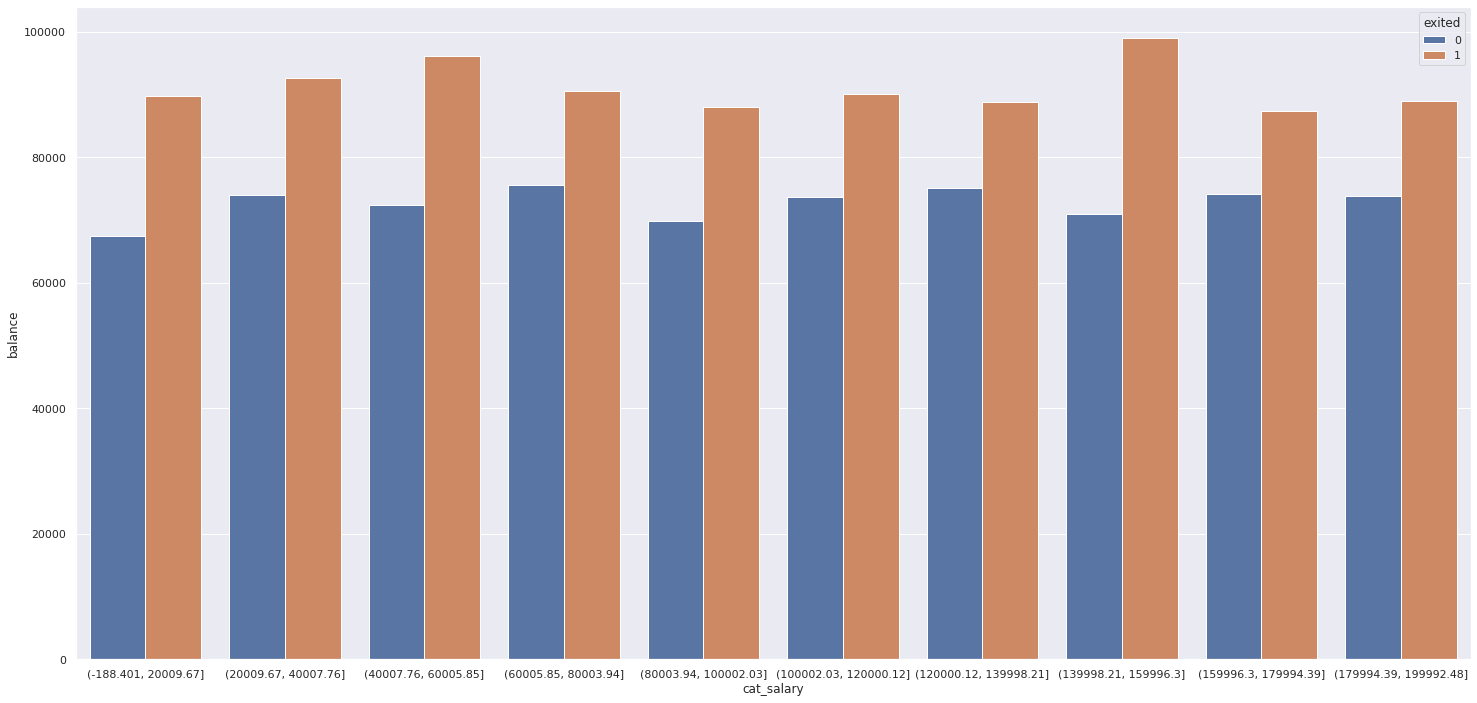

In [81]:
# plot
sns.barplot(x='cat_salary', y='balance', hue='exited', data=aux)

### H15. Non-active customers who do not have a credit card tend to evade more than non-active customers with a credit card - FALSE
No correlation between these variables

In [82]:
# create a crosstab and percentage values
aux = pd.crosstab(df3['exited'], [df3['is_active_member'], df3['has_cr_card']]).T.reset_index()
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100

In [83]:
# select only non-active customers
aux_2 = aux.loc[aux['is_active_member'] == 0, 'percentage']

In [84]:
# create bars 100
aux_3 = pd.DataFrame({k:100 for k in range(0, 2)}, index=[0]).T.reset_index()

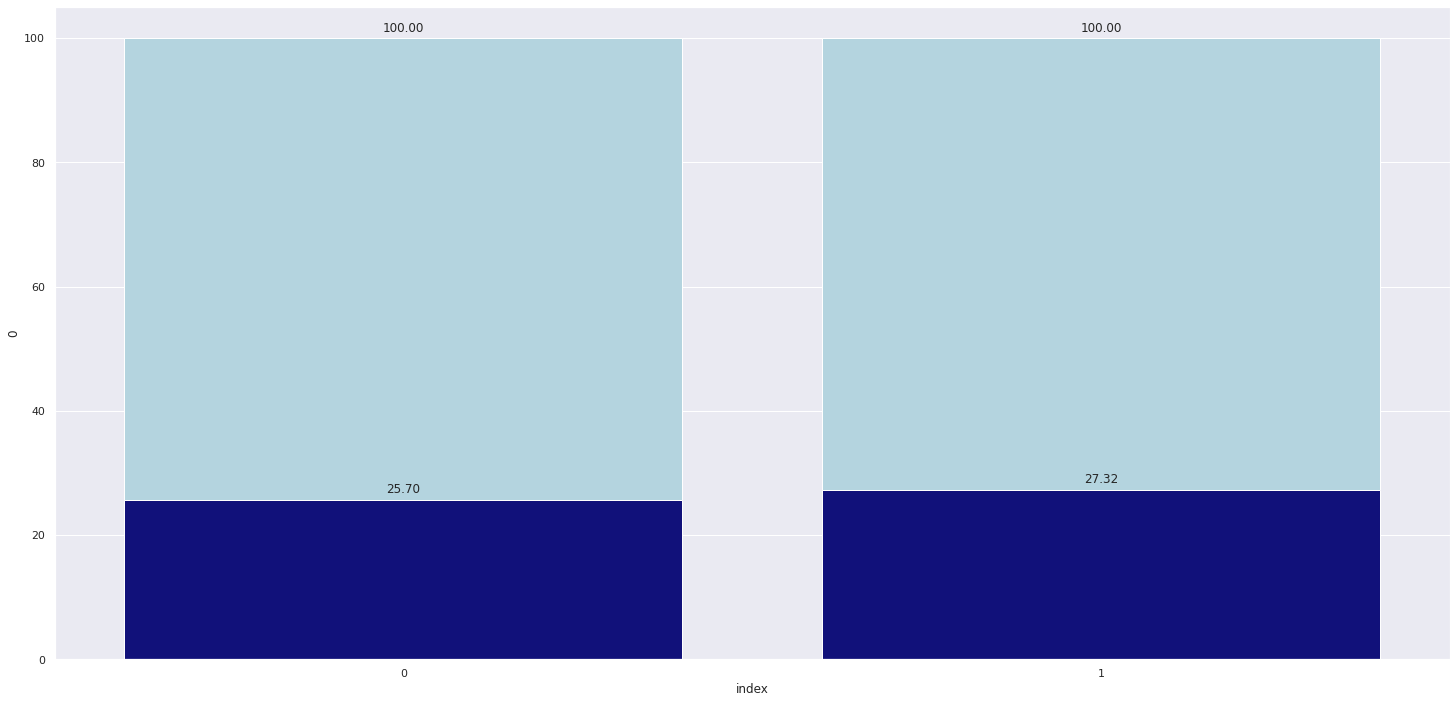

In [85]:
# plot percentage bar of each value for credit_card value for non-active members
bar1 = sns.barplot(x=aux_3['index'], y=aux_3[0], color='lightblue')
bar2 = sns.barplot(x=aux_2.index, y=aux_2.values, color='darkblue', order = aux_2.index)


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H16. Younger credit card customers tend to evade less than Younger no credit card customers - FALSE
No correlation between these variables

In [86]:
# create a crosstab and percentage values
aux = pd.crosstab(df3['exited'], [df3['age_category'], df3['has_cr_card']]).T.reset_index()
aux['percentage'] = aux[1] / (aux[0] + aux[1]) * 100

In [87]:
# select only customers with age 18 - 29
aux_2 = aux.loc[aux['age_category'] == '18 - 29', 'percentage']

In [88]:
# create bars 100
aux_3 = pd.DataFrame({k:100 for k in range(0, 2)}, index=[0]).T.reset_index()

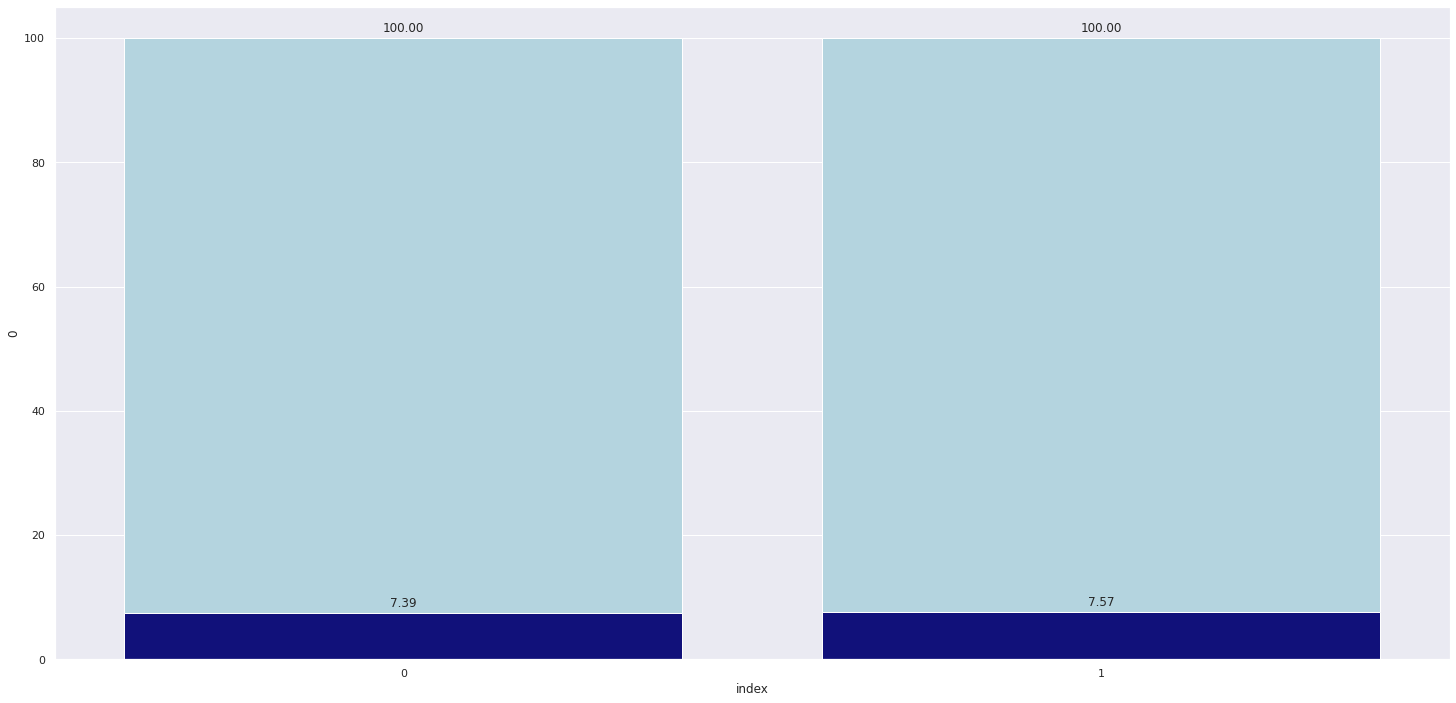

In [89]:
# plot percentage bar of each value for credit_card value for age 18 - 29
bar1 = sns.barplot(x=aux_3['index'], y=aux_3[0], color='lightblue')
bar2 = sns.barplot(x=aux_2.index, y=aux_2.values, color='darkblue', order = aux_2.index)


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

### H17. People who have spent a higher percentage of life as a customer tend to evade less - TRUE
The average customer lifetime percentage is higher for those who have not dropped out. However, the difference is minimal and perhaps not relevant.

In [90]:
# create aux groupby DataFrame with perc_tenure and exited
aux = df3[['perc_tenure', 'exited']].groupby('exited').mean().reset_index()
aux['perc_tenure'] = aux['perc_tenure'] * 100

In [91]:
# create bars 100
aux_2 = pd.DataFrame({k:100 for k in range(0, 2)}, index=[0]).T.reset_index()

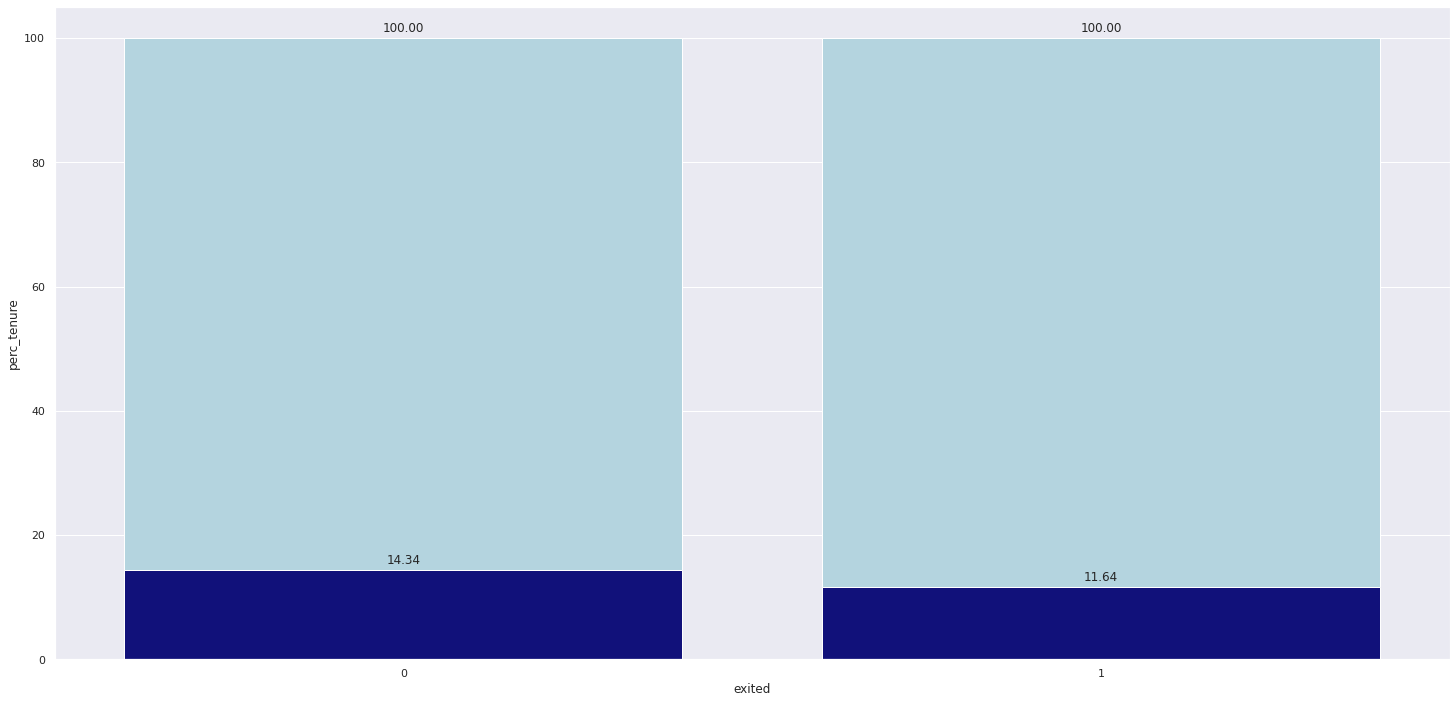

In [92]:
# plot percentage bar
bar1 = sns.barplot(x=aux_2['index'], y=aux_2[0], color='lightblue')
bar2 = sns.barplot(x=aux['exited'], y=aux['perc_tenure'], color='darkblue')


# annot
for p in bar2.patches:
            bar2.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), 
                           textcoords = 'offset points')

## 3.3. Multivariate Analysis

### 3.3.1. Separating

**Categoric**:
- geography
- gender
- cat_salary
- age_category
- score_class

**Numerical**:
- credit_score
- age
- balance
- tenure
- num_of_products
- estimated_salary
- perc_tenure
- score_account

**Binary**
- has_cr_card
- is_active_member
- have_balance

**Target**
- exited

In [93]:
# categorical variables
cat_vars = df3.loc[:, ['geography', 'gender', 'cat_salary',
                       'age_category', 'score_class', 'has_cr_card',
                       'is_active_member', 'have_balance']
                  ]

# numerical variables
num_vars = df3.loc[:, ['credit_score', 'age', 'balance', 'tenure',
                       'num_of_products', 'estimated_salary', 'perc_tenure',
                       'score_account']
                  ]

### 3.3.2 Correlation between numerical attributes

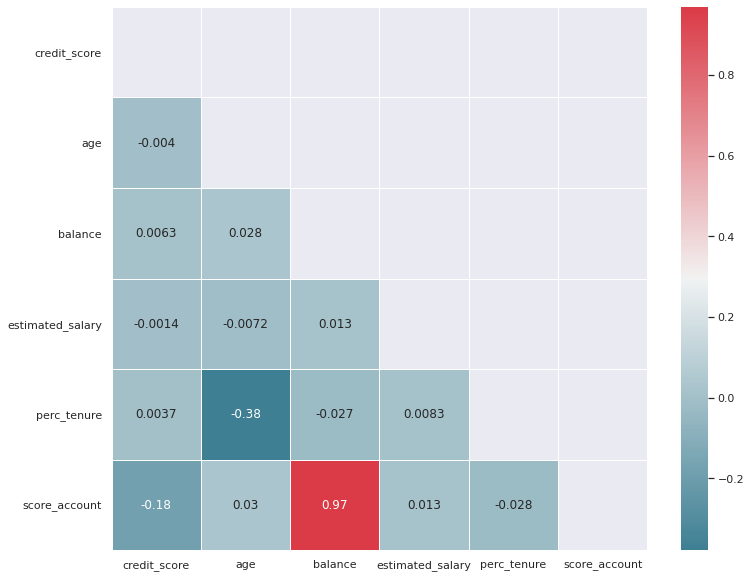

In [94]:
# calculate correlations
correlations = num_vars.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 10)

# generates a mask for the upper triangle
mask = np.triu(np.ones_like(correlations))

# generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plots the heatmap
sns.heatmap(correlations, cmap=cmap, mask=mask, linewidths=.5, annot=True)

# displays the plot
plt.show()

- 0.97 - **balance** and **score_account** are highly correlated. As expected, as one is derived from the other.

### 3.3.3 Correlation between categorical attributes

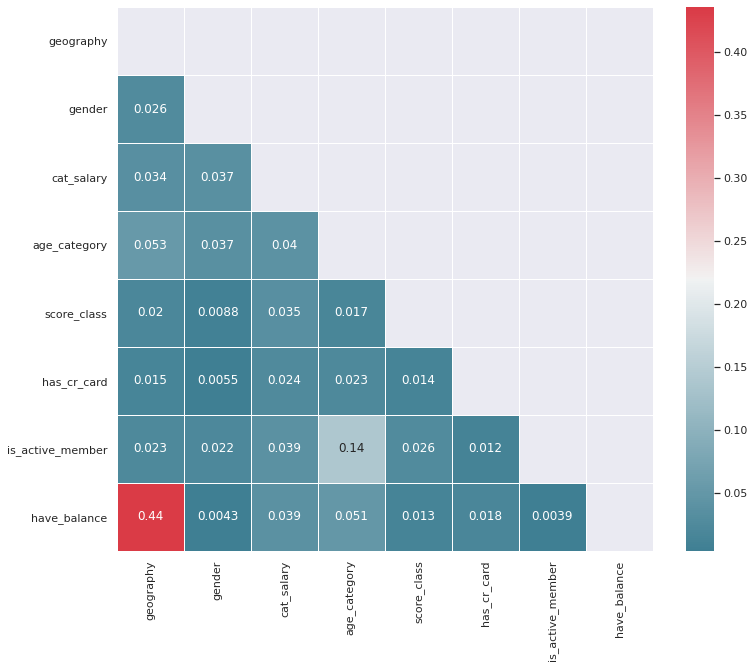

In [95]:
# calculate correlations
cat = {}

for value in cat_vars.columns:
    cols = []
    for value_ in cat_vars.columns:
        cols.append(cramer_v(cat_vars[value], cat_vars[value_]))
        
    cat[value] = cols
    
d = pd.DataFrame(cat)

d = d.set_index(d.columns)

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 10)

# generates a mask for the upper triangle
mask = np.triu(d)

# generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plots the heatmap
sns.heatmap(d, cmap=cmap, mask=mask, linewidths=.5, annot=True)

# displays the plot
plt.show()

# 4.0. DATA PREPARATION

In [149]:
df4 = df3.copy()

## 4.1. Encoding Dataset

In [150]:
# geography -> OneHotEncoding
df4 = pd.get_dummies(df4, prefix='geography', columns=['geography'])

# gender -> OneHotEncoding
df4 = pd.get_dummies(df4, prefix='gender', columns=['gender'], drop_first=True)

# score_class -> OrdinalEncoding
score_class_dict = {'high_risk': 0, 'med_risk': 1, 'low_risk': 2, 'very_low_risk': 3}
df4['score_class'] = df4['score_class'].map(score_class_dict)

# cat_salary -> OrdinalEncoding
cat_salary_dict = {'(-188.401, 20009.67]': 0, '(20009.67, 40007.76]': 1,
                    '(40007.76, 60005.85]': 2, '(60005.85, 80003.94]': 3, 
                    '(80003.94, 100002.03]':4, '(100002.03, 120000.12]':5,
                    '(120000.12, 139998.21]':6, '(139998.21, 159996.3]':7,
                    '(159996.3, 179994.39]':8, '(179994.39, 199992.48]':9}

df4['cat_salary'] = df4['cat_salary'].astype('str')
df4['cat_salary'] = df4['cat_salary'].map(cat_salary_dict)

# age_category -> OrdinalEncoding
age_category_dict = {'18 - 29': 0, '30 - 39': 1, '40 - 49': 2, '50 - 59': 3, '60 +':4}
df4['age_category'] = df4['age_category'].map(age_category_dict)

## 4.2. Split Dataset

In [151]:
# separate variable response
X = df4.drop('exited', axis=1)
y = df4.loc[:, 'exited']

# split dataset in train and test
X_train, X_test, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=32, stratify=y)

# transform y into int
y_train = y_train_.astype('int64')
y_test = y_test_.astype('int64')

## 4.3. Scalling Dataset

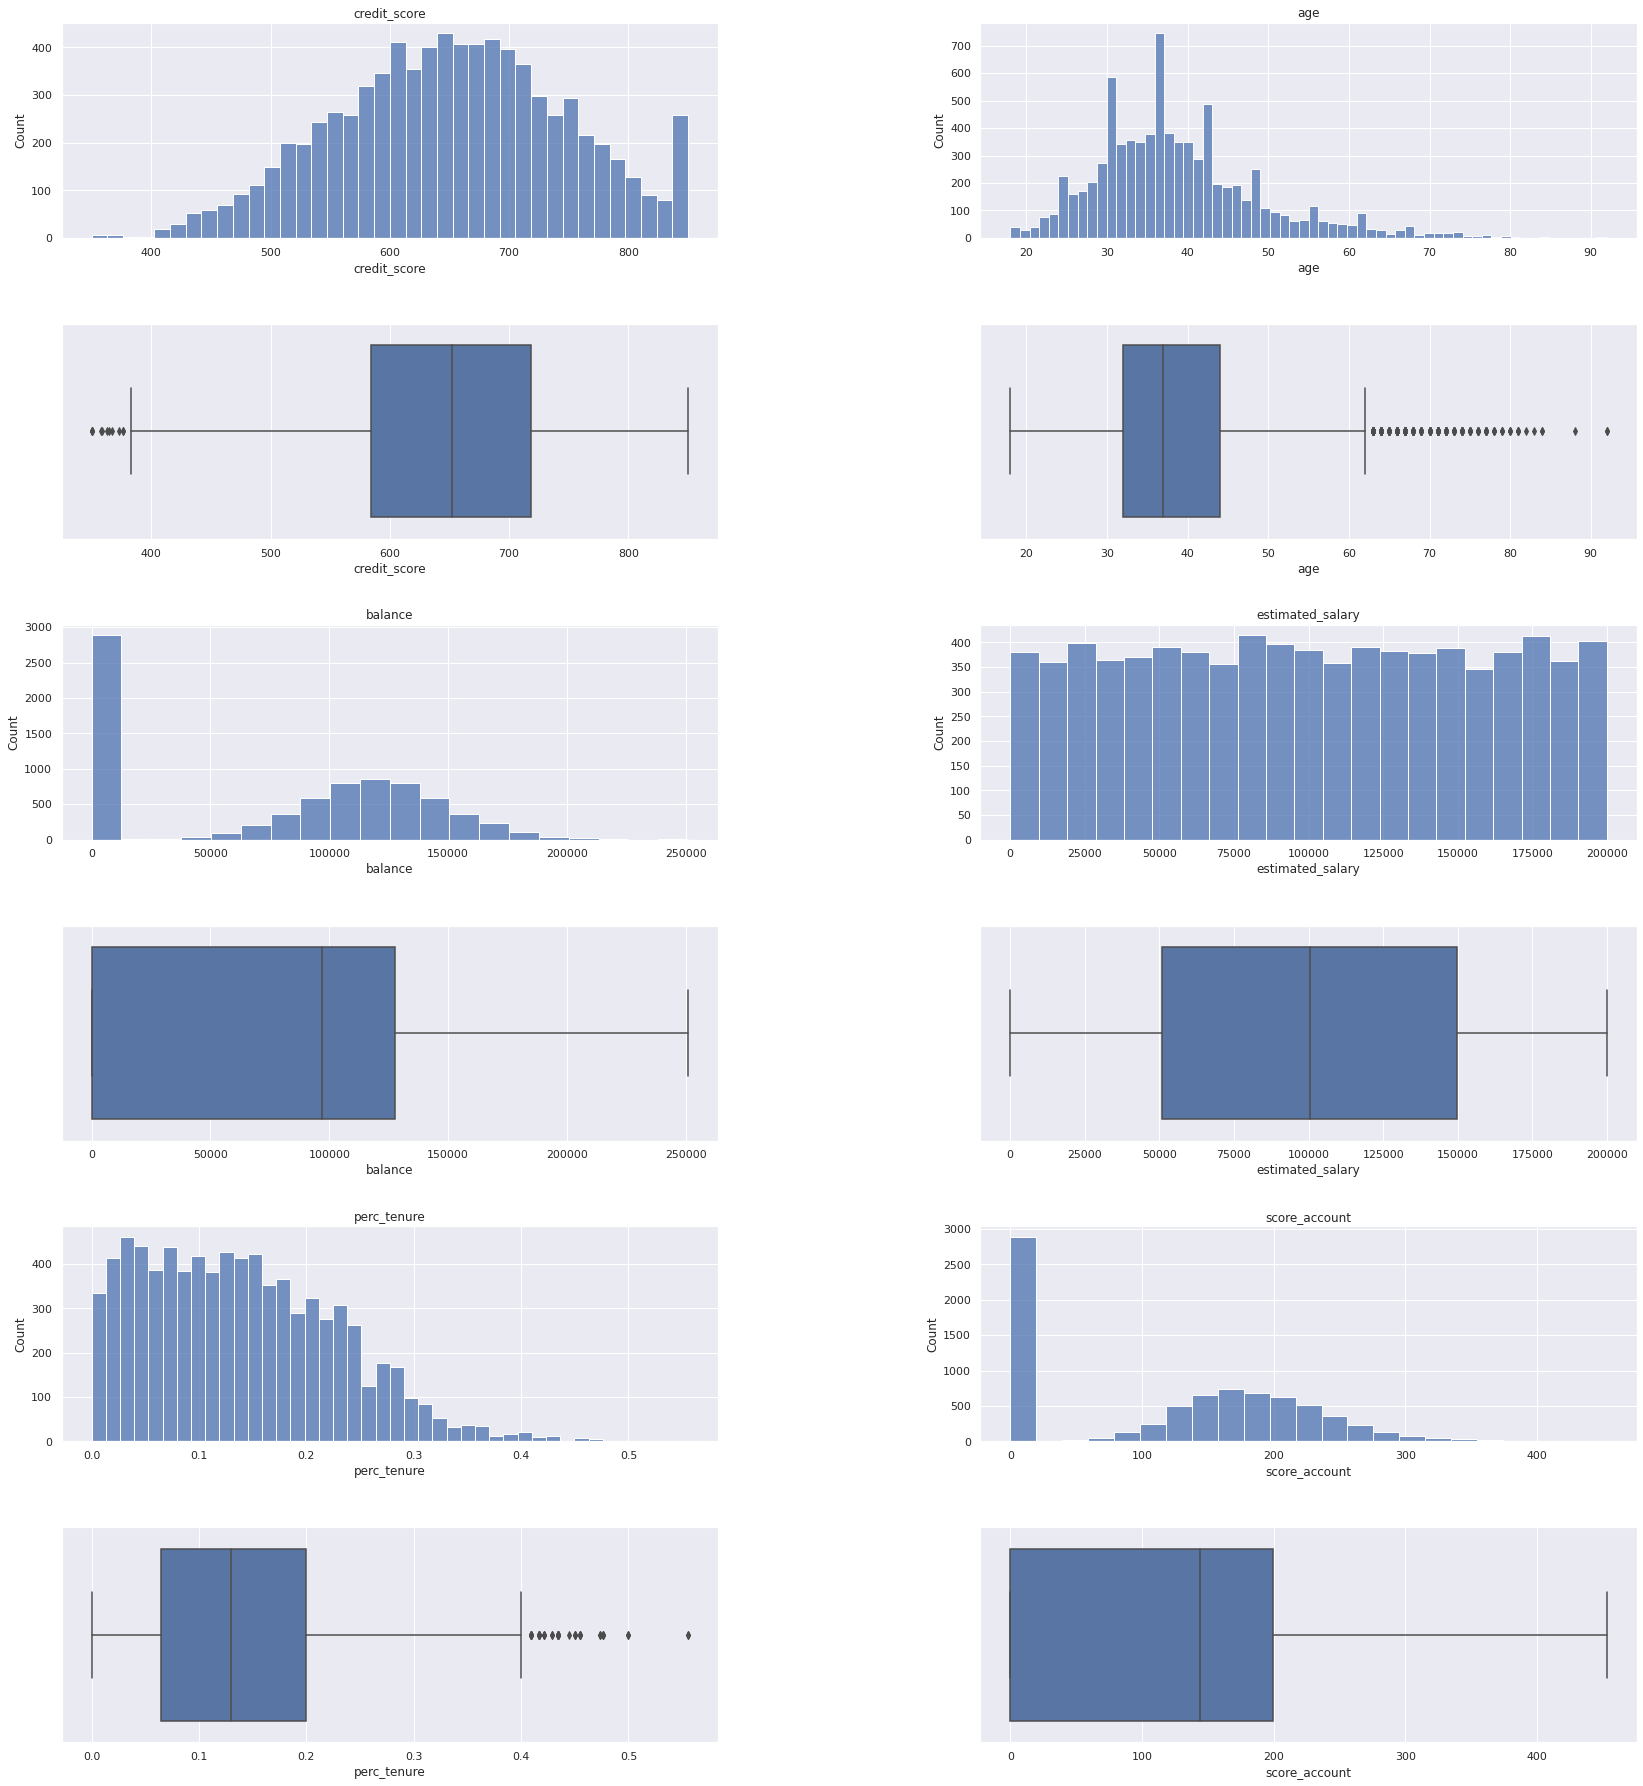

In [152]:
grid = plt.GridSpec(6, 2)

# credit_score
plt.subplot(grid[0, 0])
sns.histplot(X_train['credit_score'])

plt.title('credit_score')

plt.subplot(grid[1, 0])
sns.boxplot(x = X_train['credit_score'])

# age
plt.subplot(grid[0, 1])
sns.histplot(X_train['age'])

plt.title('age')

plt.subplot(grid[1, 1])
sns.boxplot(x = X_train['age'])

# balance
plt.subplot(grid[2, 0])
sns.histplot(X_train['balance'])

plt.title('balance')

plt.subplot(grid[3, 0])
sns.boxplot(x = X_train['balance'])

# estimated_salary
plt.subplot(grid[2, 1])
sns.histplot(X_train['estimated_salary'])

plt.title('estimated_salary')

plt.subplot(grid[3, 1])
sns.boxplot(x = X_train['estimated_salary'])

# perc_tenure
plt.subplot(grid[4, 0])
sns.histplot(X_train['perc_tenure'])

plt.title('perc_tenure')

plt.subplot(grid[5, 0])
sns.boxplot(x = X_train['perc_tenure'])

# score_account
plt.subplot(grid[4, 1])
sns.histplot(X_train['score_account'])

plt.title('score_account')

plt.subplot(grid[5, 1])
sns.boxplot(x = X_train['score_account'])


plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1, 
                    top=2, 
                    wspace=0.4, 
                    hspace=0.40)

MinMaxScaler:
- credit_score
- estimated_salary

RobustScaler:
- age
- balance
- perc_tenure
- score_account

In [153]:
# scalers
mms = pp.MinMaxScaler()
rs = pp.RobustScaler()

In [154]:
# credit_score -> MinMaxScaler
mms_credit_score_train = mms.fit(X_train[['credit_score']].values)
mms_credit_score_test = mms.fit(X_test[['credit_score']].values)
X_train['credit_score'] = mms_credit_score_train.transform(X_train[['credit_score']].values)
X_test['credit_score'] = mms_credit_score_test.transform(X_test[['credit_score']].values)

# estimated_salary -> MinMaxScaler
mms_estimated_salary_train = mms.fit(X_train[['estimated_salary']].values)
mms_estimated_salary_test = mms.fit(X_test[['estimated_salary']].values)
X_train['estimated_salary'] = mms_estimated_salary_train.transform(X_train[['estimated_salary']].values)
X_test['estimated_salary'] = mms_estimated_salary_test.transform(X_test[['estimated_salary']].values)

# age -> RobustScaler
rs_age_train = rs.fit(X_train[['age']].values)
rs_age_test = rs.fit(X_test[['age']].values)
X_train['age'] = rs_age_train.transform(X_train[['age']].values)
X_test['age'] = rs_age_test.transform(X_test[['age']].values)

# balance -> RobustScaler
rs_balance_train = rs.fit(X_train[['balance']].values)
rs_balance_test = rs.fit(X_test[['balance']].values)
X_train['balance'] = rs_balance_train.transform(X_train[['balance']].values)
X_test['balance'] = rs_balance_test.transform(X_test[['balance']].values)

# perc_tenure -> RobustScaler
rs_perc_tenure_train = rs.fit(X_train[['perc_tenure']].values)
rs_perc_tenure_test = rs.fit(X_test[['perc_tenure']].values)
X_train['perc_tenure'] = rs_perc_tenure_train.transform(X_train[['perc_tenure']].values)
X_test['perc_tenure'] = rs_perc_tenure_test.transform(X_test[['perc_tenure']].values)

# score_account -> RobustScaler
rs_score_account_train = rs.fit(X_train[['score_account']].values)
rs_score_account_test = rs.fit(X_test[['score_account']].values)
X_train['score_account'] = rs_score_account_train.transform(X_train[['score_account']].values)
X_test['score_account'] = rs_score_account_test.transform(X_test[['score_account']].values)

In [155]:
X_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,perc_tenure,score_account,score_class,age_category,have_balance,cat_salary,geography_France,geography_Germany,geography_Spain,gender_Male
7879,0.614,0.583333,6,-0.170051,1,1,0,0.395102,0.054113,-0.152188,1,2,1,3,1,0,0,1
9128,0.686,0.500000,1,0.183233,1,1,0,0.439739,-0.780731,0.145918,1,2,1,4,0,1,0,0
651,0.740,1.250000,7,-0.764874,1,1,1,0.073491,0.041209,-0.735416,2,3,0,0,1,0,0,1
1975,0.544,-0.166667,5,-0.764874,2,1,0,0.255238,0.102041,-0.735416,1,1,0,2,1,0,0,0
5985,0.710,-0.333333,7,-0.232812,1,1,1,0.324071,0.613276,-0.249245,2,1,1,3,0,0,1,1


# 5.0. Feature Selection

## 5.1. Boruta as Feature Selector

In [103]:
X_train_nn = X_train.values
y_train_nn = y_train.values.ravel()

### 5.1.1. Boruta with ExtraTreeSclassfier

In [104]:
etc = en.ExtraTreesClassifier(n_jobs=-1)

boruta_etc = BorutaPy(etc, n_estimators='auto', verbose=0, random_state=32).fit(X_train_nn, y_train_nn)

In [105]:
cols_selected_etc = boruta_etc.support_.tolist()

In [106]:
cols_selected_boruta_etc = X_train.iloc[:, cols_selected_etc].columns.to_list()
cols_selected_boruta_etc

['age', 'num_of_products', 'is_active_member', 'perc_tenure', 'age_category']

### 5.1.2. Boruta with XGBost

In [107]:
xgb = xgboost.XGBRegressor(n_jobs=-1)

boruta_xgb = BorutaPy(xgb, n_estimators='auto', verbose=0, random_state=32).fit(X_train_nn, y_train_nn)

In [108]:
cols_selected_xgb = boruta_xgb.support_.tolist()

In [109]:
cols_selected_xgb = X_train.iloc[:, cols_selected_xgb].columns.to_list()
cols_selected_xgb

['age',
 'balance',
 'num_of_products',
 'is_active_member',
 'score_account',
 'geography_Germany',
 'gender_Male']

## 5.2. Manual Feature Selection

<AxesSubplot:>

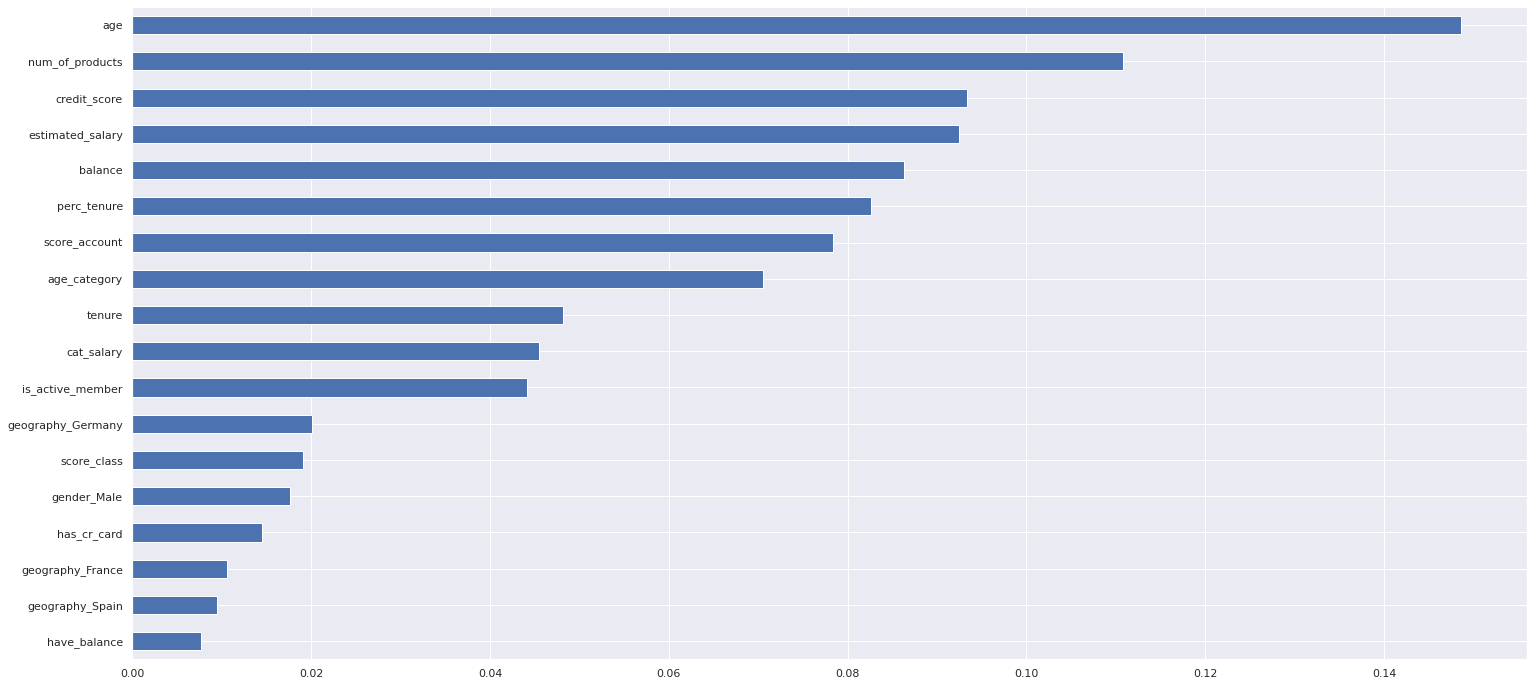

In [110]:
rf_model = en.RandomForestClassifier(n_jobs = -1)
rf_model.fit(X_train, y_train)

feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')

## 5.3. Recursive Feature Elimination (RFE)

In [111]:
rfe = RFE(estimator=rf_model, n_features_to_select=5)
fit = rfe.fit(X_train, y_train)

In [112]:
for i in range(X_train.shape[1]):
    print('{} - Rank: {}'.format(X_train.columns[i], rfe.ranking_[i]))

credit_score - Rank: 1
age - Rank: 1
tenure - Rank: 5
balance - Rank: 1
num_of_products - Rank: 2
has_cr_card - Rank: 11
is_active_member - Rank: 7
estimated_salary - Rank: 1
perc_tenure - Rank: 1
score_account - Rank: 3
score_class - Rank: 9
age_category - Rank: 4
have_balance - Rank: 14
cat_salary - Rank: 6
geography_France - Rank: 12
geography_Germany - Rank: 8
geography_Spain - Rank: 13
gender_Male - Rank: 10


## 5.4. Features Final List

In [157]:
features = ['age', 'num_of_products', 'perc_tenure', 'cat_salary', 'score_class']

X_train = X_train[features]
X_test = X_test[features]

# 6.0. Machine Learning Modeling

In [114]:
# Logistic Regression
# KNN
# GaussianNB
# RandomForestClassifier
# LGBMClassifier
# CatBoostClassifier
# XGBoost

## 6.1. No Balance

In [115]:
list_models = [lm.LogisticRegression(random_state=32),
               nhb.KNeighborsClassifier(),
               nb.GaussianNB(), 
               LGBMClassifier(n_jobs=-1),
               en.RandomForestClassifier(n_jobs =-1), 
               cb.CatBoostClassifier(verbose=0),
               xgboost.XGBClassifier(n_jobs=-1, objective='binary:logistic', use_label_encoder=False, verbosity=0)
               ]

In [116]:
skfold = StratifiedKFold(n_splits=5)

In [117]:
dict_results = {}

for model in list_models:
    result = cross_validate(model, X_train.values, y_train.values.ravel(), cv=skfold,
                            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    
    dict_results[type(model).__name__] = [np.mean(result['test_accuracy']), np.mean(result['test_precision']),
                                          np.mean(result['test_recall']), np.mean(result['test_f1']),
                                          np.mean(result['test_roc_auc'])]

In [118]:
df_scores = pd.DataFrame(dict_results).T
df_scores.columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']

In [119]:
df_scores.sort_values(by='ROC_AUC', ascending=False)

,Accuracy,Precision,Recall,F1,ROC_AUC
CatBoostClassifier,0.835250,0.655775,0.403067,0.499250,0.812904
LGBMClassifier,0.836625,0.661152,0.406748,0.503416,0.804138
XGBClassifier,0.827250,0.622883,0.385276,0.475872,0.786490
RandomForestClassifier,0.806625,0.534031,0.402454,0.458838,0.767417
GaussianNB,0.797000,0.505098,0.211656,0.298142,0.766191
KNeighborsClassifier,0.812625,0.563828,0.354601,0.435240,0.736208
LogisticRegression,0.777375,0.270605,0.052761,0.088214,0.732199


## 6.2. SMOTE

In [120]:
# defines the resampler
resampler_smote = SMOTE(random_state=32, n_jobs=-1)

# makes the balancing
X_balanced_smote, y_balanced_smote = resampler_smote.fit_resample(X_train, y_train)

In [121]:
dict_results_smote = {}

for model in list_models:
    result = cross_validate(model, X_balanced_smote.values, y_balanced_smote.values.ravel(), cv=skfold,
                            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    
    dict_results_smote[type(model).__name__] = [np.mean(result['test_accuracy']), np.mean(result['test_precision']),
                                          np.mean(result['test_recall']), np.mean(result['test_f1']),
                                          np.mean(result['test_roc_auc'])]

In [122]:
df_scores_smote = pd.DataFrame(dict_results_smote).T
df_scores_smote.columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']

In [123]:
df_scores_smote.sort_values(by='ROC_AUC', ascending=False)

,Accuracy,Precision,Recall,F1,ROC_AUC
XGBClassifier,0.863187,0.897381,0.820565,0.837544,0.941503
CatBoostClassifier,0.864600,0.889950,0.831083,0.846880,0.940078
LGBMClassifier,0.856515,0.882432,0.821350,0.839162,0.934527
RandomForestClassifier,0.847253,0.857223,0.833909,0.838528,0.922314
KNeighborsClassifier,0.792386,0.762267,0.849922,0.803618,0.866796
GaussianNB,0.721115,0.715640,0.733752,0.724571,0.775552
LogisticRegression,0.699922,0.714400,0.666091,0.689350,0.746685


## 6.3. Tomek

In [124]:
# defines the resampler
resampler_tomek = TomekLinks(n_jobs=-1)

# makes the balancing
X_balanced_tomek, y_balanced_tomek = resampler_tomek.fit_resample(X_train, y_train)

In [125]:
dict_results_tomek = {}

for model in list_models:
    result = cross_validate(model, X_balanced_tomek.values, y_balanced_tomek.values.ravel(), cv=skfold,
                            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    
    dict_results_tomek[type(model).__name__] = [np.mean(result['test_accuracy']), np.mean(result['test_precision']),
                                          np.mean(result['test_recall']), np.mean(result['test_f1']),
                                          np.mean(result['test_roc_auc'])]

In [126]:
df_scores_tomek = pd.DataFrame(dict_results_tomek).T
df_scores_tomek.columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']

In [127]:
df_scores_tomek.sort_values(by='ROC_AUC', ascending=False)

,Accuracy,Precision,Recall,F1,ROC_AUC
CatBoostClassifier,0.843726,0.706384,0.453988,0.552651,0.830929
LGBMClassifier,0.845161,0.714529,0.453988,0.554910,0.821346
XGBClassifier,0.837073,0.673814,0.453374,0.541909,0.805261
RandomForestClassifier,0.818811,0.595727,0.460736,0.519526,0.794405
GaussianNB,0.802375,0.574483,0.271779,0.368871,0.779598
KNeighborsClassifier,0.822331,0.630234,0.400613,0.489594,0.761615
LogisticRegression,0.772373,0.360659,0.092638,0.147348,0.745898


## 6.4. SMOTE + Tomek

In [128]:
# defines the resampler
resampler_smotetomek = SMOTETomek(random_state=32, n_jobs=-1)

# makes the balancing
X_balanced_smotetomek, y_balanced_smotetomek = resampler_smotetomek.fit_resample(X_train, y_train)

In [129]:
dict_results_smotetomek = {}

for model in list_models:
    result = cross_validate(model, X_balanced_smotetomek.values, y_balanced_smotetomek.values.ravel(), cv=skfold,
                            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    
    dict_results_smotetomek[type(model).__name__] = [np.mean(result['test_accuracy']), np.mean(result['test_precision']),
                                          np.mean(result['test_recall']), np.mean(result['test_f1']),
                                          np.mean(result['test_roc_auc'])]

In [130]:
df_scores_smotetomek = pd.DataFrame(dict_results_smotetomek).T
df_scores_smotetomek.columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']

In [131]:
df_scores_smotetomek.sort_values(by='ROC_AUC', ascending=False)

,Accuracy,Precision,Recall,F1,ROC_AUC
XGBClassifier,0.873934,0.903650,0.835605,0.853653,0.947319
CatBoostClassifier,0.870275,0.896228,0.836769,0.855263,0.945024
LGBMClassifier,0.865121,0.890318,0.832281,0.851378,0.941159
RandomForestClassifier,0.866615,0.875029,0.856051,0.859897,0.935611
KNeighborsClassifier,0.812169,0.780645,0.868353,0.822105,0.888042
GaussianNB,0.732879,0.727258,0.745179,0.736090,0.790077
LogisticRegression,0.713099,0.727537,0.681350,0.703655,0.760636


# 7.0. Test Dataset

In [134]:
model = xgboost.XGBClassifier(random_state=32, n_jobs=-1)

In [137]:
model.fit(X_balanced_smotetomek.values, y_balanced_smotetomek.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=32,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [162]:
model.score(X_test, y_test)

0.815